# DTSA 5509 Supervised Learning Project

## Predicting Redo Ablation Risk: A Supervised Learning-Based Clinical Scoring System

Github: https://github.com/Vorlon41/Master-of-Data-Science-CU-Boulder-Colorado/tree/main/Machine%20Learning/DTSA%205509%20Introduction%20to%20Machine%20Learning%20Supervised%20Learning/Final

# Problem Description

Atrial fibrillation (AF) is the most common sustained cardiac arrhythmia and is associated with increased morbidity, including stroke, heart failure, and recurrent hospitalizations. A key challenge in AF management is the heterogeneity in patient presentation, treatment response, and long-term outcomes — particularly the need for redo ablation procedures after initial intervention. The problem leverages supervised learning models to predict redo ablation and help build a clincial scoring systme to aid clinicians in determining the risk of redo ablations. 

## Objectives

Predict Redo Ablation Using Supervised Machine Learning
Build and evaluate predictive models (e.g., logistic regression, random forests, neural networks) to identify patients at risk for redo ablation based on clinical, procedural, and physiologic features.

Develop a Clinically Interpretable Risk Score
Derive and validate a point-based clinical risk score from model features to aid clinicians in assessing the likelihood of redo ablation, facilitating real-time decision-making and patient stratification.

Compare Model Performance and Interpretability
Evaluate the trade-off between accuracy and interpretability across different models to determine the optimal approach for clinical implementation.

Assess Model Generalizability and Clinical Utility
Use cross-validation and external test sets to assess generalizability and provide insight into how the model can be integrated into care pathways to reduce procedural failures.

# Description of the Data

This database contains 128 ECG Holter recordings from 93 adult subjects, collected between May 2019 and May 2023. Recorded at 125Hz using Fukuda Holter monitors with modified CC5 and NASA leads, each ~24-hour recording includes a diagnosis from free-text medical reports. Of 145 recordings, 17 were excluded due to duplicates, missing data, or poor signal quality. Ninety-eight recordings were annotated by certified cardiologists, with 80 from subjects with atrial fibrillation (AF). An additional 30 recordings lack rhythm annotations. Per Biton et al. [10], ~100 recordings were re-annotated by a cardiology fellow, stratified by age, sex, and AF diagnosis. Patient data was anonymized per HIPAA, with random 3-digit IDs (000–143) and dates shifted by ≥1 year. ECGs are stored in WFDB format, with two channels: ECG1 (CC5) and ECG2 (NASA).



In [415]:
import pandas as pd
from IPython.display import display

# Define the data as a dictionary where keys are column names and values are descriptions
data = {
    "Column Name": [
        "Subject_ID", "Data_ID", "Annotated", "Height", "Weight", "BMI", 
        "Date_Holter", "Holter_start_time", "Holter_recording_length", 
        "Indication_Holter", "Age_at_Holter", "Sex", "AF_Type", 
        "Previously_Documented_AFL", "Previous_AF_Ablation", 
        "PPM_on_Holter", "PPM_after_Holter", "PPM_Indication", "PPM_Date", 
        "Date_of_First_Diagnosis_of_AF_AFL", "AF_Duration_Months", 
        "Antiarrhythmic_Drug_nonBB", "BB", "Anticoagulation", 
        "Date_of_1st_AF_Ablation", "Ablation1_PVI", "Ablation1_CTI", 
        "Ablation1_Others", "Date_Redo_AF_Ablation", "Redo_Detail", 
        "Echo_Date", "Echo_LAD", "Echo_LVEF", "Echo_LV_Asynergy", 
        "Moderate_or_Severe_MR", "Moderate_or_Severe_TR", 
        "Moderate_or_Severe_AS", "Moderate_or_Severe_AR", 
        "CHF", "HTN", "DM", "Vascular_Diseases", "Stroke", "Comments"
    ],
    "Description": [
        "Unique subject identifier",
        "3-digit Holter recording identifier",
        "Indicates rhythm annotations (Y/N)",
        "Patient height (m)",
        "Patient weight (kg)",
        "Body Mass Index (calculated)",
        "Holter recording date",
        "Recording start time (hh:mm AM/PM)",
        "Recording duration (hh:mm:ss)",
        "Reason for Holter",
        "Subject age (years)",
        "Gender (male/female)",
        "Diagnosis from medical report",
        "Prior atrial flutter (Y/N)",
        "Prior AF ablation (Y/N)",
        "Pacemaker during Holter (Y/N)",
        "Pacemaker after Holter (Y/N)",
        "Pacemaker reason",
        "Pacemaker implantation date",
        "First AF/AFL diagnosis date",
        "AF duration (months)",
        "Medications (non-BB antiarrhythmics)",
        "Medications (Beta-Blockers)",
        "Medications (anticoagulants)",
        "Date of first AF ablation",
        "Pulmonary vein isolation (Y/N)",
        "Cavotricuspid isthmus ablation (Y/N)",
        "Other ablation types",
        "Date of redo AF ablation",
        "Redo ablation details",
        "Echocardiogram date",
        "Left atrial diameter",
        "Left ventricular ejection fraction",
        "Left ventricular asynergy (Y/N)",
        "Mitral Regurgitation (moderate/severe)",
        "Tricuspid Regurgitation (moderate/severe)",
        "Aortic Stenosis (moderate/severe)",
        "Aortic Regurgitation (moderate/severe)",
        "Congestive Heart Failure (Y/N)",
        "Hypertension (Y/N)",
        "Diabetes Mellitus (Y/N)",
        "Vascular Diseases (Y/N)",
        "Prior stroke (Y/N)",
        "Miscellaneous notes"
    ]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame with some styling
display(df.style.set_properties(**{
    'text-align': 'left',
    'border': '1px solid black',
    'padding': '5px'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#f0f0f0'), ('font-weight', 'bold'), ('text-align', 'left')]}
]).set_caption("Holter Database Column Descriptions"))

,Column Name,Description
0,Subject_ID,Unique subject identifier
1,Data_ID,3-digit Holter recording identifier
2,Annotated,Indicates rhythm annotations (Y/N)
3,Height,Patient height (m)
4,Weight,Patient weight (kg)
5,BMI,Body Mass Index (calculated)
6,Date_Holter,Holter recording date
7,Holter_start_time,Recording start time (hh:mm AM/PM)
8,Holter_recording_length,Recording duration (hh:mm:ss)
9,Indication_Holter,Reason for Holter


In [417]:
# Libraries
import os
import sys
import math
import contextlib
import joblib
import numpy as np
import pandas as pd
from scipy.stats import pointbiserialr, spearmanr, chi2_contingency, chi2, stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.tree import export_graphviz, plot_tree, export_text
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, average_precision_score,
    precision_score, recall_score, f1_score, accuracy_score, make_scorer,
    precision_recall_curve, roc_curve, auc, brier_score_loss,
    precision_recall_fscore_support, ConfusionMatrixDisplay
)
from sklearn.calibration import calibration_curve  # Correct location
from imblearn.over_sampling import SMOTE
import shap
from xgboost import XGBClassifier
import statsmodels.api as sm
from statsmodels.tools import add_constant

## Pre Processing

In [420]:
# Set the file path
file_path = r"C:\Users\chris\OneDrive\Desktop\A fib Unsupervised Learning Project\Hierarchical Clustering\HC5_with_RiskLabels.xlsx"

# Load the Excel file into a DataFrame
data_with_ecg = pd.read_excel(file_path)

# Preview the data
data_with_ecg.head()

,Data_ID,Height,Weight,BMI,Age_at_Holter,Sex,Previously_Documented_AFL,Previous_AF_Ablation,PPM_on_Holter,PPM_after_Holter,...,Has_Aortic_Dissect,Redo_re_pvi,Redo_cti,Redo_svci,Redo_pwi,Redo_non_pv,Redo_at ablation,Redo_Ablation,HC_Cluster_5,HC_Cluster_5_Risk_Label
0,1,1.73,63.5,21.2,65,1,0,1,0,0,...,0,1,0,1,0,0,0,1,2,Very High Risk
1,2,1.66,55.9,20.3,62,1,1,1,0,0,...,0,1,1,0,0,0,0,1,2,Very High Risk
2,3,1.66,63.3,23.0,79,1,1,0,0,1,...,0,0,0,0,0,0,0,0,1,Moderate Risk
3,4,1.65,53.0,19.5,76,1,0,0,0,0,...,0,0,0,0,0,0,0,0,4,Low Risk
4,5,1.76,98.7,31.9,47,1,1,1,0,0,...,0,1,1,1,0,0,0,1,3,High Risk


In [422]:
print(data_with_ecg.columns.tolist())


['Data_ID', 'Height', 'Weight', 'BMI', 'Age_at_Holter', 'Sex', 'Previously_Documented_AFL', 'Previous_AF_Ablation', 'PPM_on_Holter', 'PPM_after_Holter', 'AF_Duration_Months', 'Ablation1_PVI', 'Ablation1_CTI', 'Echo_LAD', 'Echo_LVEF', 'Moderate_or_Severe_MR', 'Moderate_or_Severe_TR', 'Moderate_or_Severe_AS', 'Moderate_or_Severe_AR', 'CHF', 'HTN', 'Age_75_or_Older', 'DM', 'Stroke', 'Vascular_Diseases', 'HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD', 'HRV_SDSD', 'HRV_CVNN', 'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN', 'HRV_IQRNN', 'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_pNN50', 'HRV_pNN20', 'HRV_MinNN', 'HRV_MaxNN', 'HRV_HTI', 'HRV_TINN', 'Shannon_Entropy', 'Holter_AF_monitoring_after_ablation', 'Holter_Palpitation', 'Holter_Syncope', 'Holter_VA_monitoring', 'Holter_AF_monitoring_without_ablation', 'Holter_Bradycardia', 'Holter_Others', 'Holter_Angina', 'Holter_ESUS', 'AF_Type_PAF', 'AF_Type_PerAF', 'AF_Type_non_AF', 'Antiarrhythmic_Drug_nonBB_amiodarone', 'Antiarrhythmic_Drug_nonBB_aprindine'

### Data Cleaning

I previously cleaned this data for use with my unsupervised learning project. ECK features were extracted, RR intervals, heart rate variability, shannon entropy, was extracted and appened to the dataset. Columns with 100% missing data were removed. Categorical variables with more than 2 variables were one hot encoded to 0 and 1. Some binary variables were missing the negative values but had positive values. If a binary variables was missing, a 0 was imputed. Column means were imputed for continuous variables. 

## Exploratory Data Analysis

In [438]:

continuous = [
    "Height", "Weight", "BMI", "Age_at_Holter", "AF_Duration_Months", "Echo_LAD", "Echo_LVEF",
    "HRV_MeanNN", "HRV_SDNN", "HRV_RMSSD", "HRV_SDSD", "HRV_CVNN", "HRV_CVSD", "HRV_MedianNN",
    "HRV_MadNN", "HRV_MCVNN", "HRV_IQRNN", "HRV_Prc20NN", "HRV_Prc80NN", "HRV_pNN50", "HRV_pNN20",
    "HRV_MinNN", "HRV_MaxNN", "HRV_HTI", "HRV_TINN", "Shannon_Entropy"
]
categorical = [
    'Sex', 'Previously_Documented_AFL', 'Previous_AF_Ablation', 'PPM_on_Holter', 'PPM_after_Holter',
    'Ablation1_PVI', 'Ablation1_CTI', 'Moderate_or_Severe_MR', 'Moderate_or_Severe_TR',
    'Moderate_or_Severe_AS', 'Moderate_or_Severe_AR', 'CHF', 'HTN', 'Age_75_or_Older', 'DM',
    'Stroke', 'Vascular_Diseases', 'Holter_AF_monitoring_after_ablation', 'Holter_Palpitation',
    'Holter_Syncope', 'Holter_VA_monitoring', 'Holter_AF_monitoring_without_ablation',
    'Holter_Bradycardia', 'Holter_Others', 'Holter_Angina', 'Holter_ESUS', 'AF_Type_PAF',
    'AF_Type_PerAF', 'AF_Type_non_AF', 'Antiarrhythmic_Drug_nonBB_amiodarone',
    'Antiarrhythmic_Drug_nonBB_aprindine', 'Antiarrhythmic_Drug_nonBB_bepridil',
    'Antiarrhythmic_Drug_nonBB_cibenzoline', 'Antiarrhythmic_Drug_nonBB_frecainide',
    'Antiarrhythmic_Drug_nonBB_pilsicainide', 'Antiarrhythmic_Drug_nonBB_verapamil',
    'Antiarrhythmic_Drug_BB_bisoprolol', 'Antiarrhythmic_Drug_BB_carvedilol',
    'Antiarrhythmic_Drug_BB_metoprolol', 'Anticoagulation_apixaban', 'Anticoagulation_dabigatran',
    'Anticoagulation_edoxaban', 'Anticoagulation_rivaroxaban', 'Anticoagulation_warfarin',
    'Is_NOAC', 'Is_Class_I', 'Is_Class_III', 'Is_CCB', 'Is_BetaBlocker',
    'Asynergy_anterior_group', 'Asynergy_apical', 'Asynergy_diffuse', 'Asynergy_inferior',
    'Asynergy_none', 'Asynergy_septal', 'Has_PPM', 'Has_SSS', 'Has_Stroke', 'Has_ESRD',
    'Has_AF_on_Holter', 'Has_Malignancy', 'Has_MI', 'Has_ICD', 'Has_Ablation',
    'Has_Brugada', 'Has_Aortic_Dissect', 'Redo_Ablation'
]
null = [
    "Data_ID", "Holter_start_time", "Holter_recording_length"
]


In [429]:
print("Summary Statistics for Continuous Variables:")
print(data_with_ecg[continuous].describe())


Summary Statistics for Continuous Variables:
           Height      Weight         BMI  Age_at_Holter  AF_Duration_Months  \
count  128.000000  128.000000  128.000000     128.000000          128.000000   
mean     1.642984   62.446774   22.996774      65.789062           11.070312   
std      0.084890   13.689955    4.020047      12.061295           23.303943   
min      1.450000   35.900000   14.400000      29.000000            0.000000   
25%      1.590000   54.075000   20.450000      60.000000            0.000000   
50%      1.642984   61.050000   22.700000      67.500000            0.000000   
75%      1.702500   68.825000   24.725000      74.250000           10.250000   
max      1.850000  112.600000   39.400000      87.000000          143.000000   

         Echo_LAD   Echo_LVEF   HRV_MeanNN     HRV_SDNN    HRV_RMSSD  ...  \
count  128.000000  128.000000   128.000000   128.000000   128.000000  ...   
mean    39.608000   63.200000   765.706030   103.984340   111.200598  ...   
std

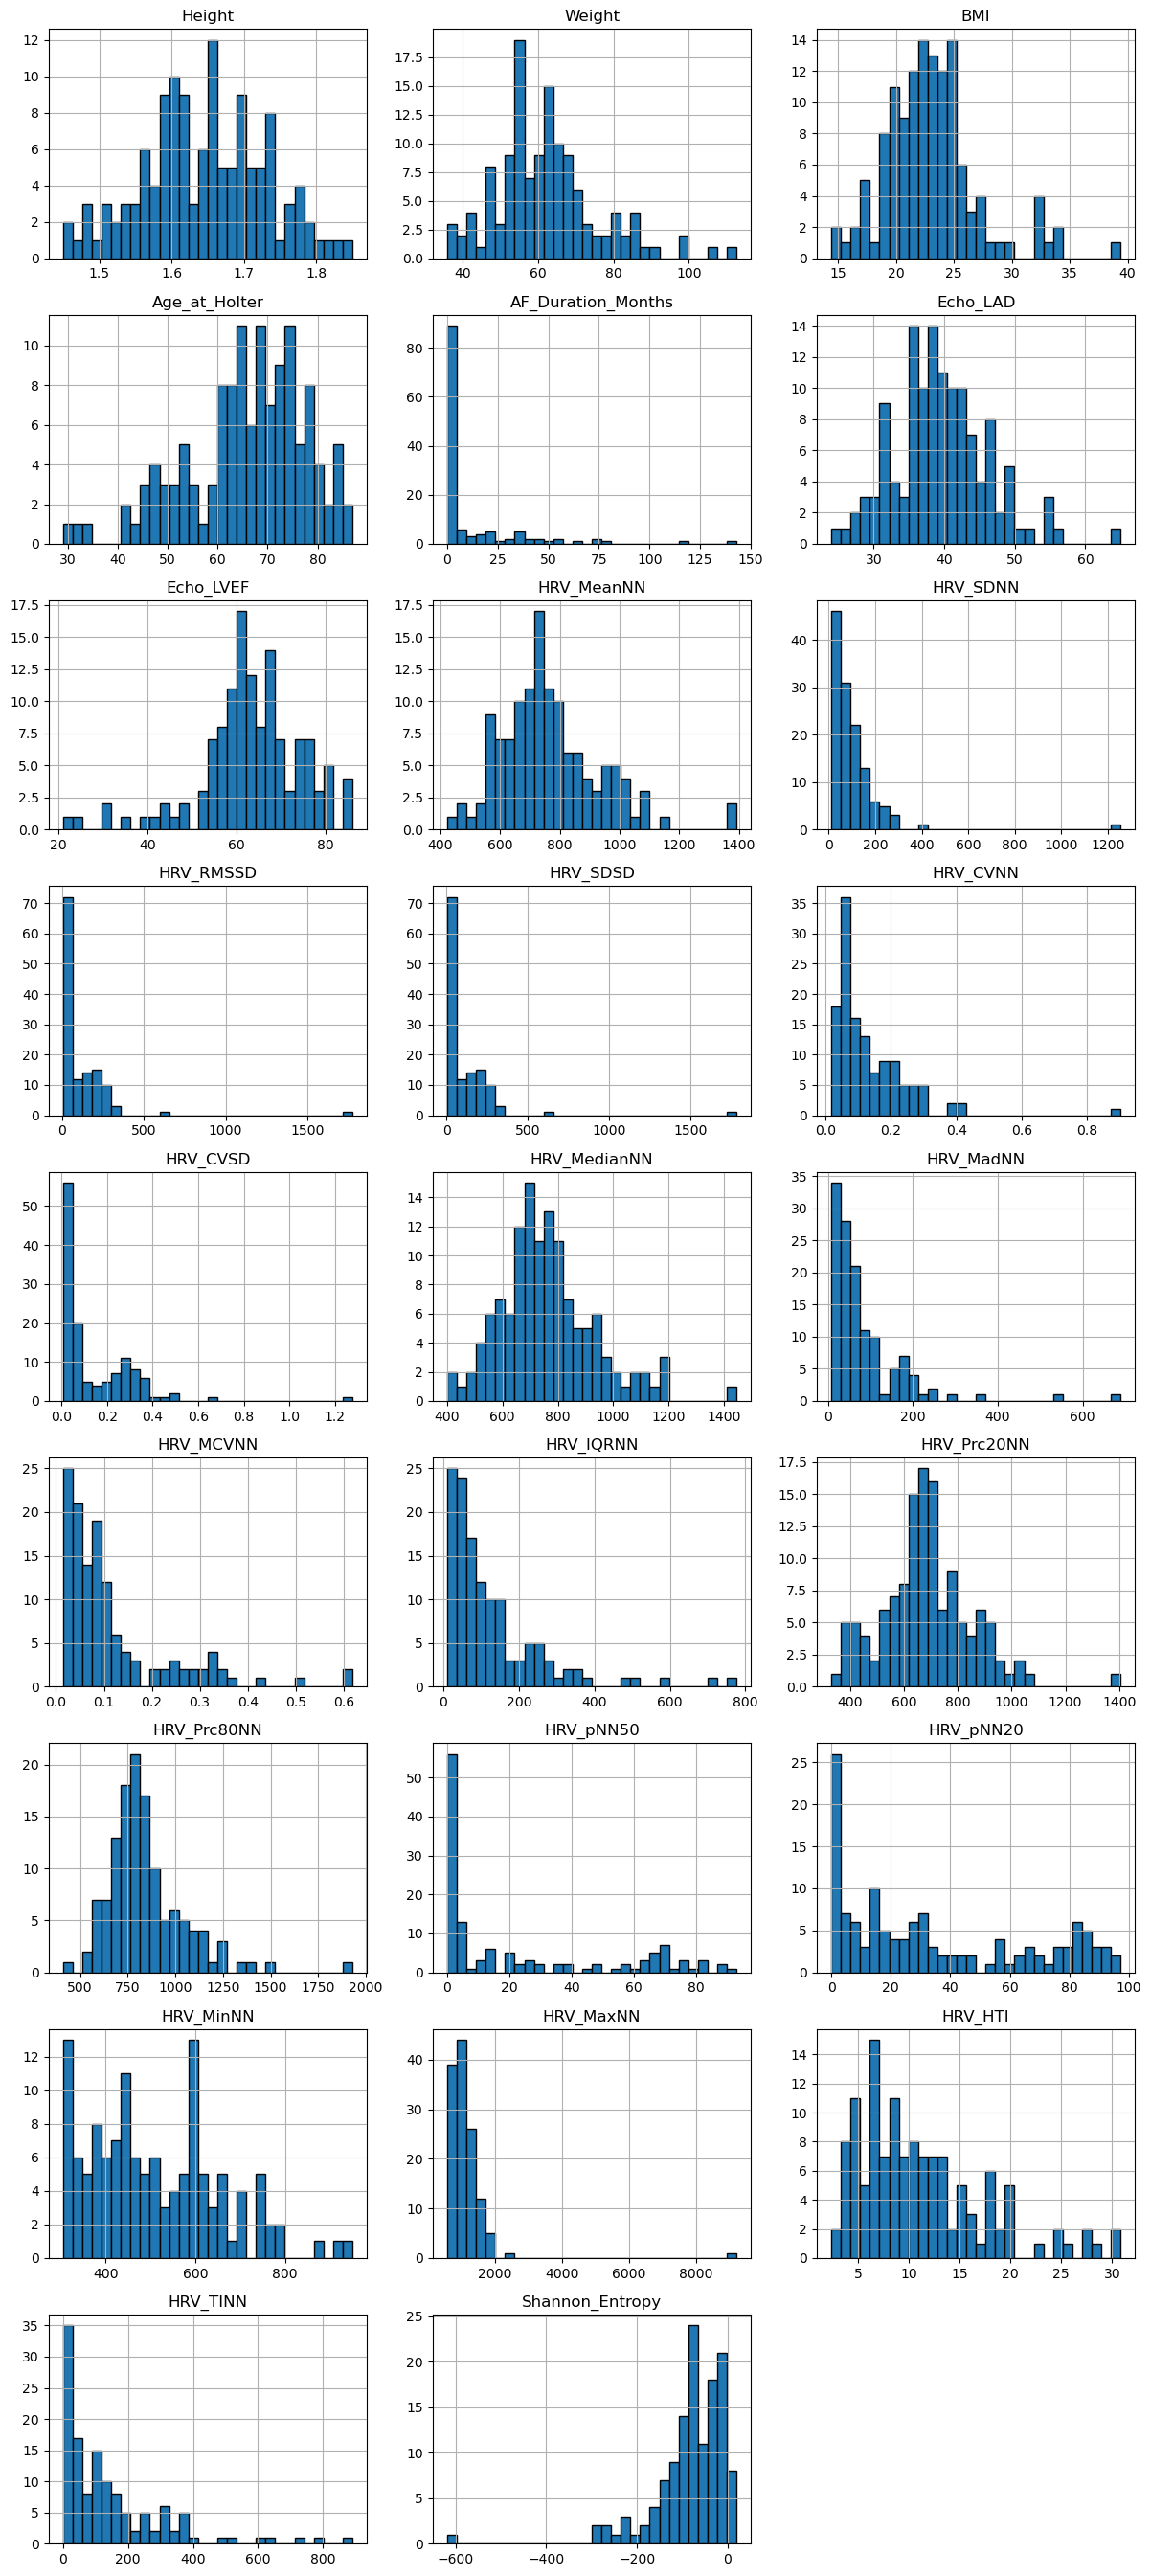

In [431]:
# Settings
cols_per_row = 3
num_vars = len(continuous)
num_rows = math.ceil(num_vars / cols_per_row)

# Create subplots
fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(cols_per_row * 4, num_rows * 3))
axes = axes.flatten()  

for idx, col in enumerate(continuous):
    ax = axes[idx]
    data_with_ecg[col].hist(ax=ax, bins=30, edgecolor='black')
    ax.set_title(col)
    ax.set_xlabel("")
    ax.set_ylabel("")

# Hide unused axes if any
for j in range(idx + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [440]:
print("Chi-squared p-values for categorical variables vs Redo_Ablation:\n")
for col in categorical:
    if col != "Redo_Ablation":
        table = pd.crosstab(data_with_ecg[col], data_with_ecg["Redo_Ablation"])
        if table.shape == (2, 2):  # only apply to 2x2 tables
            _, p, _, _ = chi2_contingency(table)
            print(f"{col}: p = {p:.4f}")


Chi-squared p-values for categorical variables vs Redo_Ablation:

Sex: p = 0.1687
Previously_Documented_AFL: p = 0.0106
Previous_AF_Ablation: p = 0.0000
PPM_on_Holter: p = 1.0000
PPM_after_Holter: p = 1.0000
Ablation1_PVI: p = 0.0000
Ablation1_CTI: p = 0.0000
Moderate_or_Severe_MR: p = 0.7359
Moderate_or_Severe_TR: p = 1.0000
Moderate_or_Severe_AR: p = 1.0000
CHF: p = 0.8739
HTN: p = 1.0000
Age_75_or_Older: p = 0.0840
DM: p = 0.2059
Stroke: p = 0.4730
Vascular_Diseases: p = 0.0392
Holter_AF_monitoring_after_ablation: p = 0.0000
Holter_Palpitation: p = 0.0003
Holter_Syncope: p = 1.0000
Holter_VA_monitoring: p = 0.3342
Holter_AF_monitoring_without_ablation: p = 0.2059
Holter_Bradycardia: p = 1.0000
Holter_Others: p = 1.0000
Holter_Angina: p = 0.7359
Holter_ESUS: p = 0.4294
AF_Type_PAF: p = 0.1400
AF_Type_PerAF: p = 0.0173
AF_Type_non_AF: p = 0.0003
Antiarrhythmic_Drug_nonBB_amiodarone: p = 0.3183
Antiarrhythmic_Drug_nonBB_aprindine: p = 1.0000
Antiarrhythmic_Drug_nonBB_bepridil: p = 0.00

In [442]:
SigCategorical = [
    "Previously_Documented_AFL",
    "Previous_AF_Ablation",
    "Ablation1_PVI",
    "Ablation1_CTI",
    "Vascular_Diseases",
    "Holter_AF_monitoring_after_ablation",
    "Holter_Palpitation",
    "AF_Type_PerAF",
    "AF_Type_non_AF",
    "Antiarrhythmic_Drug_nonBB_bepridil",
    "Antiarrhythmic_Drug_BB_bisoprolol",
    "Anticoagulation_apixaban",
    "Anticoagulation_edoxaban",
    "Is_NOAC",
    "Is_Class_III",
    "Is_BetaBlocker"
]
correlation_results = []

for var in SigCategorical:
    if data_with_ecg[var].nunique() == 2:
        corr, pval = pointbiserialr(data_with_ecg[var], data_with_ecg['Redo_Ablation'])
        correlation_results.append({
            "Variable": var,
            "Correlation": round(corr, 4),
            "R^2": round(corr ** 2, 4),
            "p-value": round(pval, 4)
        })

# Display the results
import pandas as pd
pd.DataFrame(correlation_results)

,Variable,Correlation,R^2,p-value
0,Previously_Documented_AFL,0.2525,0.0638,0.0040
1,Previous_AF_Ablation,0.6090,0.3709,0.0000
2,Ablation1_PVI,0.5774,0.3333,0.0000
3,Ablation1_CTI,0.4829,0.2332,0.0000
4,Vascular_Diseases,-0.2104,0.0442,0.0172
5,Holter_AF_monitoring_after_ablation,0.6078,0.3694,0.0000
6,Holter_Palpitation,-0.3388,0.1148,0.0001
7,AF_Type_PerAF,0.2384,0.0568,0.0067
8,AF_Type_non_AF,-0.3403,0.1158,0.0001
9,Antiarrhythmic_Drug_nonBB_bepridil,0.2736,0.0749,0.0018


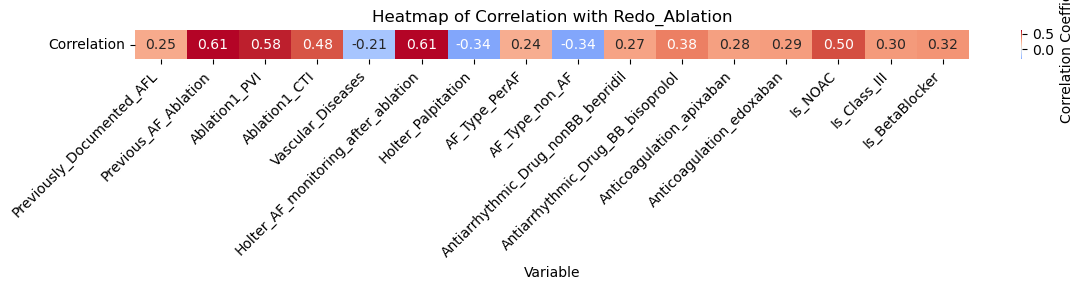

In [444]:
correlation_data = pd.DataFrame({
    "Variable": [
        "Previously_Documented_AFL", "Previous_AF_Ablation", "Ablation1_PVI", "Ablation1_CTI", "Vascular_Diseases",
        "Holter_AF_monitoring_after_ablation", "Holter_Palpitation", "AF_Type_PerAF", "AF_Type_non_AF",
        "Antiarrhythmic_Drug_nonBB_bepridil", "Antiarrhythmic_Drug_BB_bisoprolol", "Anticoagulation_apixaban",
        "Anticoagulation_edoxaban", "Is_NOAC", "Is_Class_III", "Is_BetaBlocker"
    ],
    "Correlation": [
        0.2525, 0.6090, 0.5774, 0.4829, -0.2104, 0.6078, -0.3388, 0.2384, -0.3403,
        0.2736, 0.3771, 0.2837, 0.2917, 0.4967, 0.2981, 0.3234
    ]
})

# Create a heatmap
plt.figure(figsize=(12, 3))  # Adjust height for a horizontal layout
heatmap_data = correlation_data.set_index("Variable").T
sns.heatmap(
    heatmap_data,
    annot=True,
    cmap="coolwarm",
    center=0,
    fmt=".2f",
    cbar_kws={'label': 'Correlation Coefficient'}
)

# Rotate x-axis labels and adjust alignment
plt.xticks(rotation=45, ha='right')  # Rotate and right-align
plt.yticks(rotation=0)
plt.title("Heatmap of Correlation with Redo_Ablation")
plt.tight_layout()
plt.show()


### Logistic Regression

In [104]:
#  Map Risk Label to Numeric
risk_mapping = {
    'Low Risk': 0,
    'Moderate Risk': 1,
    'High Risk': 2,
    'Very High Risk': 3,
    'Extreme Risk': 4
}
data_with_ecg['HC_Cluster_5_Risk_Num'] = data_with_ecg['HC_Cluster_5_Risk_Label'].map(risk_mapping)

# Drop unwanted columns
drop_cols = ['Data_ID', 'Redo_re_pvi', 'Redo_cti', 'Redo_svci', 'Redo_pwi', 'Redo_non_pv', 'Redo_at ablation', 
             'Redo_Ablation', 'HC_Cluster_5_Risk_Label']
X = data_with_ecg.drop(columns=drop_cols)

# Define target variable
y = data_with_ecg['Redo_Ablation']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  Fit logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))


Confusion Matrix:
 [[14  4]
 [ 5  3]]

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.78      0.76        18
           1       0.43      0.38      0.40         8

    accuracy                           0.65        26
   macro avg       0.58      0.58      0.58        26
weighted avg       0.64      0.65      0.65        26

ROC AUC Score: 0.7777777777777779


C:\Users\chris\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [106]:
feature_importance = pd.Series(model.coef_[0], index=X.columns).sort_values(key=np.abs, ascending=False)
print("\nTop Features by Coefficient (Magnitude):\n", feature_importance.head(15))



Top Features by Coefficient (Magnitude):
 HC_Cluster_5_Risk_Num                  1.186170
HC_Cluster_5                          -0.950279
Previous_AF_Ablation                   0.928737
Holter_AF_monitoring_after_ablation    0.734859
Ablation1_PVI                          0.651990
Holter_Palpitation                    -0.598681
BMI                                    0.475210
Is_NOAC                                0.449463
AF_Type_non_AF                        -0.354956
Ablation1_CTI                          0.348478
Anticoagulation_edoxaban               0.309643
AF_Type_PerAF                          0.302321
Is_BetaBlocker                         0.298076
HTN                                    0.260277
Antiarrhythmic_Drug_BB_bisoprolol      0.225537
dtype: float64


### Logistic Regression with SMOTE

In [109]:
# Define X and y again for clarity
X = data_with_ecg.drop(columns=[
    'Data_ID', 'Redo_re_pvi', 'Redo_cti', 'Redo_svci', 
    'Redo_pwi', 'Redo_non_pv', 'Redo_at ablation', 
    'Redo_Ablation', 'HC_Cluster_5_Risk_Label'
])
y = data_with_ecg['Redo_Ablation']

# Train/test split (before SMOTE)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Fit logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train_resampled, y_train_resampled)

# Predict and evaluate
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

Confusion Matrix:
 [[14  4]
 [ 5  3]]

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.78      0.76        18
           1       0.43      0.38      0.40         8

    accuracy                           0.65        26
   macro avg       0.58      0.58      0.58        26
weighted avg       0.64      0.65      0.65        26

ROC AUC Score: 0.7291666666666667


C:\Users\chris\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Random Forrest

#### Random Forrest with SMOTE

In [113]:
# Prepare X and y
X = data_with_ecg.drop(columns=[
    'Data_ID', 'Redo_re_pvi', 'Redo_cti', 'Redo_svci', 
    'Redo_pwi', 'Redo_non_pv', 'Redo_at ablation', 
    'Redo_Ablation', 'HC_Cluster_5_Risk_Label'
])
y = data_with_ecg['Redo_Ablation']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# predict and evaluate
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

Confusion Matrix:
 [[14  4]
 [ 3  5]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.78      0.80        18
           1       0.56      0.62      0.59         8

    accuracy                           0.73        26
   macro avg       0.69      0.70      0.69        26
weighted avg       0.74      0.73      0.73        26

ROC AUC Score: 0.8090277777777778


In [115]:
# Get feature importances
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importance = feature_importance.sort_values(ascending=False)

# Display top 15
print("Top 15 Features:\n")
print(feature_importance.head(15))

Top 15 Features:

Previous_AF_Ablation                   0.118826
Ablation1_PVI                          0.100036
HC_Cluster_5_Risk_Num                  0.092722
HC_Cluster_5                           0.055228
Holter_Palpitation                     0.053606
AF_Duration_Months                     0.033777
Height                                 0.030230
Holter_AF_monitoring_after_ablation    0.027500
Age_at_Holter                          0.027183
Is_NOAC                                0.024705
Echo_LAD                               0.024348
AF_Type_non_AF                         0.022485
Shannon_Entropy                        0.018471
HRV_Prc80NN                            0.018129
HRV_MedianNN                           0.016900
dtype: float64


#### Feature Selection, Drops 50% of features

In [118]:
sfm = SelectFromModel(rf_model, threshold="median")  # or 0.01 for manual cutoff
sfm.fit(X_train_resampled, y_train_resampled)
X_train_reduced = sfm.transform(X_train_resampled)
X_test_reduced = sfm.transform(X_test)

# Refit RF
rf_reduced = RandomForestClassifier(n_estimators=100, random_state=42)
rf_reduced.fit(X_train_reduced, y_train_resampled)
y_pred_reduced = rf_reduced.predict(X_test_reduced)

In [119]:
# Apply SelectFromModel using the trained RF model
sfm = SelectFromModel(rf_model, threshold='median', prefit=True)  

# Transform the training and test sets
X_train_reduced = sfm.transform(X_train_resampled)
X_test_reduced = sfm.transform(X_test)

# Train new Random Forest on reduced feature set
rf_reduced = RandomForestClassifier(n_estimators=100, random_state=42)
rf_reduced.fit(X_train_reduced, y_train_resampled)

# Predict and evaluate
y_pred_reduced = rf_reduced.predict(X_test_reduced)
y_prob_reduced = rf_reduced.predict_proba(X_test_reduced)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_reduced))
print("\nClassification Report:\n", classification_report(y_test, y_pred_reduced))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob_reduced))


C:\Users\chris\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\chris\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Confusion Matrix:
 [[15  3]
 [ 5  3]]

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.83      0.79        18
           1       0.50      0.38      0.43         8

    accuracy                           0.69        26
   macro avg       0.62      0.60      0.61        26
weighted avg       0.67      0.69      0.68        26

ROC AUC Score: 0.7326388888888888


#### RF SMOTE Resampling of Selectfoward

In [123]:
rf_model_tuned = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    min_samples_split=5,
    min_samples_leaf=3,
    max_features='sqrt',
    random_state=42
)

# Fit on SMOTE-resampled training data
rf_model_tuned.fit(X_train_resampled, y_train_resampled)

# Evaluate
y_pred_tuned = rf_model_tuned.predict(X_test)
y_prob_tuned = rf_model_tuned.predict_proba(X_test)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tuned))
print("\nClassification Report:\n", classification_report(y_test, y_pred_tuned))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob_tuned))


Confusion Matrix:
 [[12  6]
 [ 3  5]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.67      0.73        18
           1       0.45      0.62      0.53         8

    accuracy                           0.65        26
   macro avg       0.63      0.65      0.63        26
weighted avg       0.69      0.65      0.67        26

ROC AUC Score: 0.7777777777777779


#### RF Tuning: Increased Depth and Less Split

In [126]:
rf_model_deep = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,              
    min_samples_split=2,       
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42
)

rf_model_deep.fit(X_train_resampled, y_train_resampled)

y_pred_deep = rf_model_deep.predict(X_test)
y_prob_deep = rf_model_deep.predict_proba(X_test)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_deep))
print("\nClassification Report:\n", classification_report(y_test, y_pred_deep))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob_deep))

Confusion Matrix:
 [[14  4]
 [ 3  5]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.78      0.80        18
           1       0.56      0.62      0.59         8

    accuracy                           0.73        26
   macro avg       0.69      0.70      0.69        26
weighted avg       0.74      0.73      0.73        26

ROC AUC Score: 0.8055555555555556


### XGBoost

In [129]:
# Define and train the XGBoost model
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train_resampled, y_train_resampled)

# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("XGBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nXGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("XGBoost ROC AUC Score:", roc_auc_score(y_test, y_prob_xgb))

C:\Users\chris\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:46:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Confusion Matrix:
 [[13  5]
 [ 5  3]]

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.72      0.72        18
           1       0.38      0.38      0.38         8

    accuracy                           0.62        26
   macro avg       0.55      0.55      0.55        26
weighted avg       0.62      0.62      0.62        26

XGBoost ROC AUC Score: 0.6944444444444444


### Support Vector Machines

In [132]:
# scaling + SVM
svm_model = make_pipeline(
    StandardScaler(),
    SVC(kernel='linear', probability=True, random_state=42)
)

# Train and evaluate
svm_model.fit(X_train_resampled, y_train_resampled)

y_pred_svm = svm_model.predict(X_test)
y_prob_svm = svm_model.predict_proba(X_test)[:, 1]

print("SVM Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
print("\nSVM Classification Report:\n", classification_report(y_test, y_pred_svm))
print("SVM ROC AUC Score:", roc_auc_score(y_test, y_prob_svm))


SVM Confusion Matrix:
 [[14  4]
 [ 6  2]]

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.78      0.74        18
           1       0.33      0.25      0.29         8

    accuracy                           0.62        26
   macro avg       0.52      0.51      0.51        26
weighted avg       0.59      0.62      0.60        26

SVM ROC AUC Score: 0.6111111111111112


### Random Forrest Model Turning Log change, leaf Change

In [135]:
rf_model_final = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=2,       
    max_features='log2',      
    random_state=42
)

rf_model_final.fit(X_train_resampled, y_train_resampled)

y_pred_final = rf_model_final.predict(X_test)
y_prob_final = rf_model_final.predict_proba(X_test)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_final))
print("\nClassification Report:\n", classification_report(y_test, y_pred_final))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob_final))

Confusion Matrix:
 [[14  4]
 [ 3  5]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.78      0.80        18
           1       0.56      0.62      0.59         8

    accuracy                           0.73        26
   macro avg       0.69      0.70      0.69        26
weighted avg       0.74      0.73      0.73        26

ROC AUC Score: 0.7777777777777779


#### RF Decision Tree Text Form

In [138]:
# Pick a tree (e.g., the first one)
tree = rf_model_final.estimators_[0]

# Print the tree in readable text
print(export_text(tree, feature_names=list(X.columns)))

|--- Echo_LAD <= 44.73
|   |--- Vascular_Diseases <= 0.50
|   |   |--- Height <= 1.75
|   |   |   |--- AF_Duration_Months <= 7.50
|   |   |   |   |--- Height <= 1.66
|   |   |   |   |   |--- HRV_IQRNN <= 47.92
|   |   |   |   |   |   |--- Holter_AF_monitoring_after_ablation <= 0.50
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |--- Holter_AF_monitoring_after_ablation >  0.50
|   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |--- HRV_IQRNN >  47.92
|   |   |   |   |   |   |--- Weight <= 47.85
|   |   |   |   |   |   |   |--- HRV_HTI <= 18.92
|   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |--- HRV_HTI >  18.92
|   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |--- Weight >  47.85
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- Height >  1.66
|   |   |   |   |   |--- Antiarrhythmic_Drug_nonBB_bepridil <= 0.50
|   |   |   |   |   |   |--- HRV_MaxNN <= 860.00
|   |   |   |   |   |   |   |

#### RF Decision Tree Partial Diagram

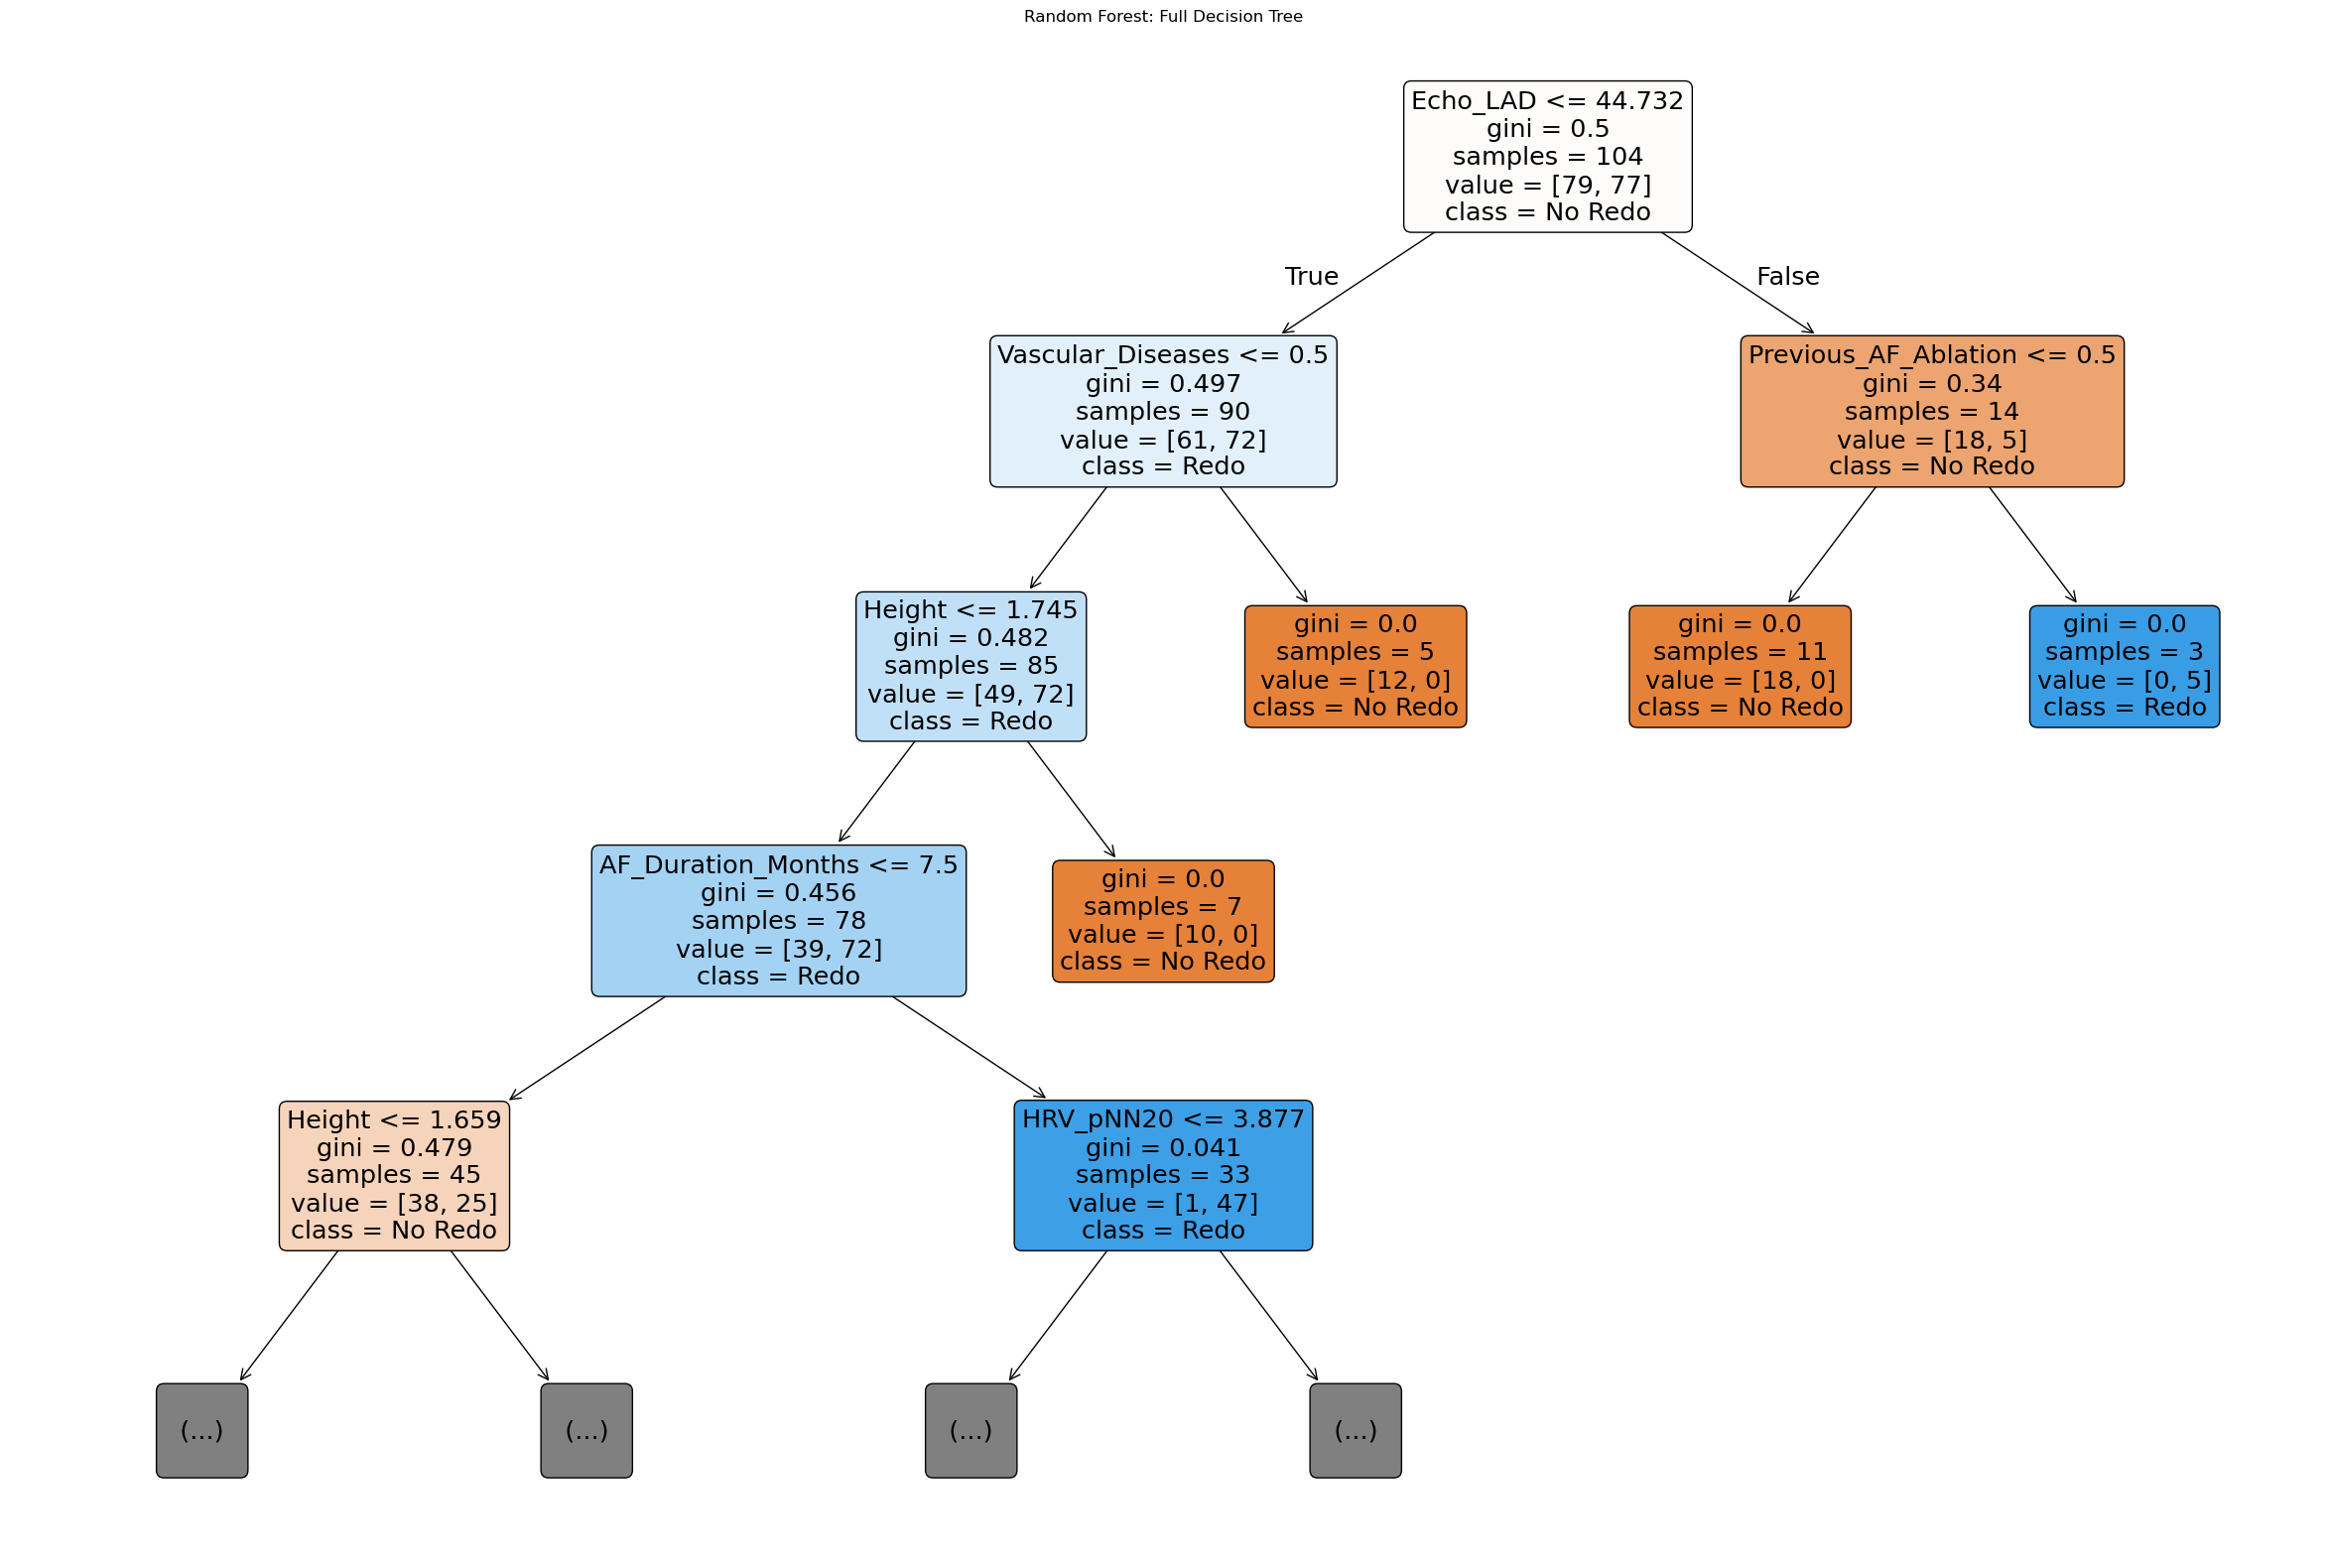

In [141]:
plt.figure(figsize=(30, 20))  # Increase figure size for visibility
plot_tree(
    rf_model_final.estimators_[0], 
    feature_names=X.columns, 
    class_names=["No Redo", "Redo"], 
    filled=True, 
    rounded=True,
    max_depth= 4 
)
plt.title("Random Forest: Full Decision Tree")
plt.show()


#### RF Crossvalidation

In [188]:
# Set up
X_array = X.to_numpy()
y_array = y.to_numpy()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Storage
roc_scores = []
recalls = []
precisions = []
accuracies = []

fold = 1
for train_idx, test_idx in skf.split(X_array, y_array):
    X_train_fold, X_test_fold = X_array[train_idx], X_array[test_idx]
    y_train_fold, y_test_fold = y_array[train_idx], y_array[test_idx]

    # Apply SMOTE to training fold only
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold, y_train_fold)

    # Train Random Forest
    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=2,
        min_samples_leaf=2,
        max_features='log2',
        random_state=42
    )
    model.fit(X_train_resampled, y_train_resampled)

    # Evaluate on test fold
    y_pred = model.predict(X_test_fold)
    y_prob = model.predict_proba(X_test_fold)[:, 1]

    print(f"\n Fold {fold} Results:")
    print(confusion_matrix(y_test_fold, y_pred))
    print(classification_report(y_test_fold, y_pred))
    roc = roc_auc_score(y_test_fold, y_prob)
    print("ROC AUC:", roc)

    # Collect metrics
    roc_scores.append(roc)
    recalls.append(recall := classification_report(y_test_fold, y_pred, output_dict=True)["1"]["recall"])
    precisions.append(precision := classification_report(y_test_fold, y_pred, output_dict=True)["1"]["precision"])
    accuracies.append((y_pred == y_test_fold).mean())
    fold += 1

# Summary
print("\n Cross-Validation Summary:")
print(f"Mean Accuracy: {np.mean(accuracies):.2f}")
print(f"Mean Recall (class 1): {np.mean(recalls):.2f}")
print(f"Mean Precision (class 1): {np.mean(precisions):.2f}")
print(f"Mean ROC AUC: {np.mean(roc_scores):.2f}")


 Fold 1 Results:
[[19  0]
 [ 2  5]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        19
           1       1.00      0.71      0.83         7

    accuracy                           0.92        26
   macro avg       0.95      0.86      0.89        26
weighted avg       0.93      0.92      0.92        26

ROC AUC: 0.9774436090225564

 Fold 2 Results:
[[16  3]
 [ 3  4]]
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        19
           1       0.57      0.57      0.57         7

    accuracy                           0.77        26
   macro avg       0.71      0.71      0.71        26
weighted avg       0.77      0.77      0.77        26

ROC AUC: 0.8421052631578947

 Fold 3 Results:
[[19  1]
 [ 0  6]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.86      1.00      0.92         6

    accuracy   

In [190]:
# Remove constant features from X
selector = VarianceThreshold(threshold=0.0)
X_cleaned = selector.fit_transform(X)
valid_columns = X.columns[selector.get_support()]
print("Features after removing constant features:", len(valid_columns))  # Should be 91

# Update X
X = pd.DataFrame(X_cleaned, columns=valid_columns)

# Train-test split (corrected syntax)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("Features in X_train_resampled:", X_train_resampled.shape[1])  # Should be 91

# Train model
final_rf_model = RandomForestClassifier(
    n_estimators=200, max_depth=10, min_samples_split=2, min_samples_leaf=2, max_features='log2', random_state=42
)
final_rf_model.fit(X_train_resampled, y_train_resampled)

# Verify feature count
print("Features in final_rf_model:", final_rf_model.n_features_in_)  # Should be 91

# Feature importance
feature_importance = pd.Series(final_rf_model.feature_importances_, index=valid_columns)
print("\nTop 15 Features by Importance:\n", feature_importance.sort_values(ascending=False).head(15))

# Evaluate model
y_pred = final_rf_model.predict(X_test)
y_prob = final_rf_model.predict_proba(X_test)[:, 1]
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

Features after removing constant features: 93
Features in X_train_resampled: 93
Features in final_rf_model: 93

Top 15 Features by Importance:
 Previous_AF_Ablation                   0.148051
Ablation1_PVI                          0.084659
HC_Cluster_5_Risk_Num                  0.075837
Holter_AF_monitoring_after_ablation    0.068432
Is_NOAC                                0.046159
Ablation1_CTI                          0.042777
HC_Cluster_5                           0.042147
Antiarrhythmic_Drug_BB_bisoprolol      0.035073
Holter_Palpitation                     0.029171
AF_Duration_Months                     0.021617
Height                                 0.021071
Anticoagulation_edoxaban               0.019377
Is_BetaBlocker                         0.018525
Weight                                 0.015435
BMI                                    0.015126
dtype: float64
Confusion Matrix:
 [[14  4]
 [ 3  5]]

Classification Report:
               precision    recall  f1-score   support

   

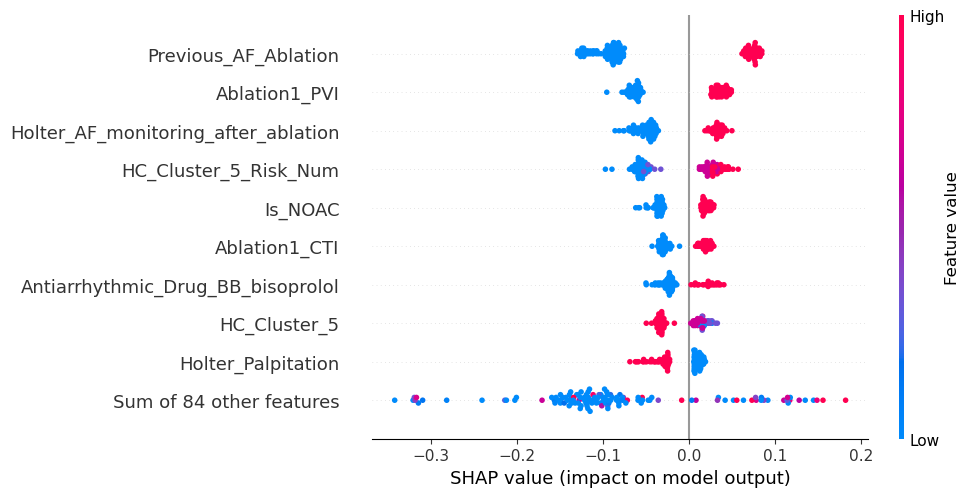

In [191]:
# Use full SHAP explanation object
explainer = shap.TreeExplainer(final_rf_model)
shap_values = explainer(X)  # This returns a shap.Explanation object

# Now just call summary plot directly
shap.plots.beeswarm(shap_values[:, :, 1])  # For class 1 (redo ablation)


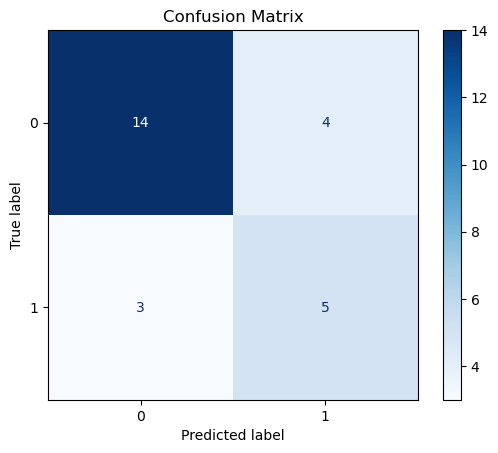

In [194]:
ConfusionMatrixDisplay.from_estimator(final_rf_model, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


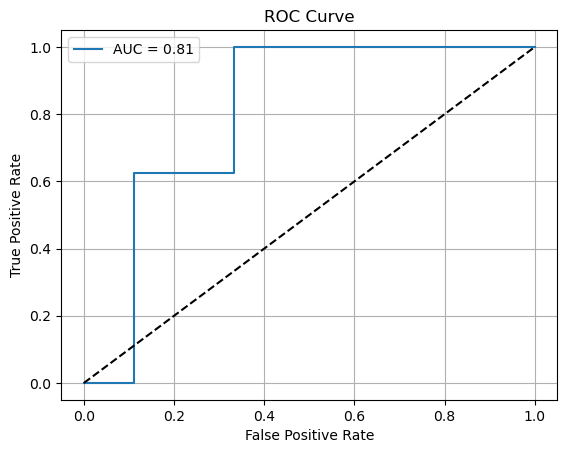

In [196]:
y_prob = final_rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

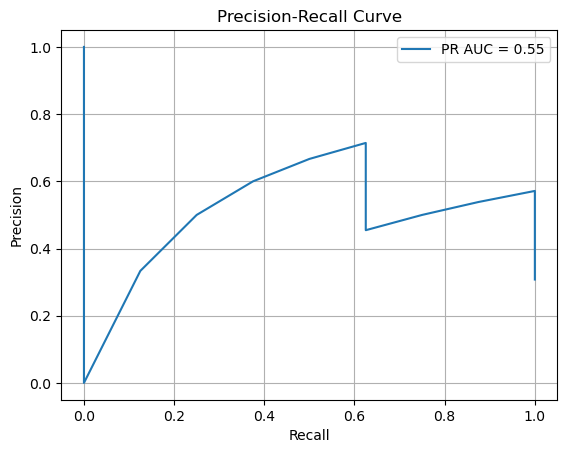

In [198]:
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)

plt.figure()
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

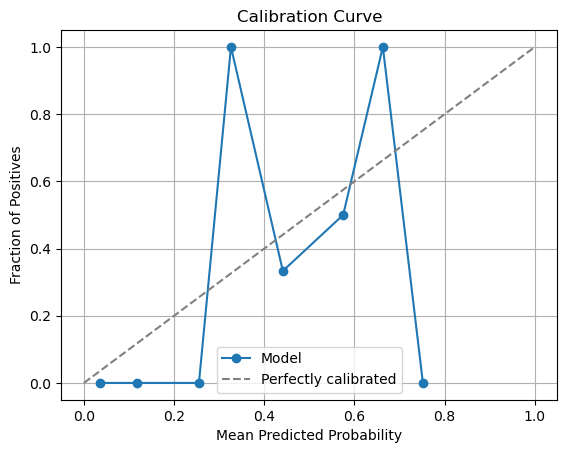

In [208]:
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)


plt.figure()
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve")
plt.legend()
plt.grid(True)
plt.show()

# Clinical Calculator

In [214]:
# Check for correlation
print(data_with_ecg[['Ablation1_PVI', 'AF_Duration_Months', 'Echo_LAD', 'Ablation1_CTI', 'Age_at_Holter']].corr())

                    Ablation1_PVI  AF_Duration_Months  Echo_LAD  \
Ablation1_PVI            1.000000            0.380650  0.099365   
AF_Duration_Months       0.380650            1.000000  0.005555   
Echo_LAD                 0.099365            0.005555  1.000000   
Ablation1_CTI            0.868000            0.320993  0.059160   
Age_at_Holter           -0.020159            0.045212  0.196156   

                    Ablation1_CTI  Age_at_Holter  
Ablation1_PVI            0.868000      -0.020159  
AF_Duration_Months       0.320993       0.045212  
Echo_LAD                 0.059160       0.196156  
Ablation1_CTI            1.000000      -0.050441  
Age_at_Holter           -0.050441       1.000000  


In [240]:
# Fit logistic regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X, y)

# Show coefficients
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': logreg.coef_[0]})
print(coef_df)

# Predict and evaluate
y_pred = logreg.predict(X)
print(classification_report(y, y_pred))

                      Feature  Coefficient
0                      Weight    -0.007241
1               Age_at_Holter     0.014356
2                         Sex    -0.432354
3   Previously_Documented_AFL     0.192193
4        Previous_AF_Ablation     1.526090
..                        ...          ...
57                    Has_ICD    -0.010282
58               Has_Ablation    -0.507999
59                Has_Brugada    -0.017112
60         Has_Aortic_Dissect    -0.250249
61               HC_Cluster_5    -0.921472

[62 rows x 2 columns]
              precision    recall  f1-score   support

           0       0.96      0.94      0.95        96
           1       0.82      0.88      0.85        32

    accuracy                           0.92       128
   macro avg       0.89      0.91      0.90       128
weighted avg       0.92      0.92      0.92       128



C:\Users\chris\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Scoring System

In [243]:
# Define score per patient
def calculate_clinical_risk_score(row):
    score = 0
    if row['Ablation1_PVI'] == 1:
        score += 1
    if row['AF_Duration_Months'] > 7.5:
        score += 1
    if row['Echo_LAD'] <= 44.73:
        score += 1
    if row['Age_at_Holter'] < 60:
        score += 1
    return score

# Apply to dataset
data_with_ecg['Clinical_Redo_Risk_Score'] = data_with_ecg.apply(calculate_clinical_risk_score, axis=1)


<function matplotlib.pyplot.title(label: 'str', fontdict: 'dict[str, Any] | None' = None, loc: "Literal['left', 'center', 'right'] | None" = None, pad: 'float | None' = None, *, y: 'float | None' = None, **kwargs) -> 'Text'>

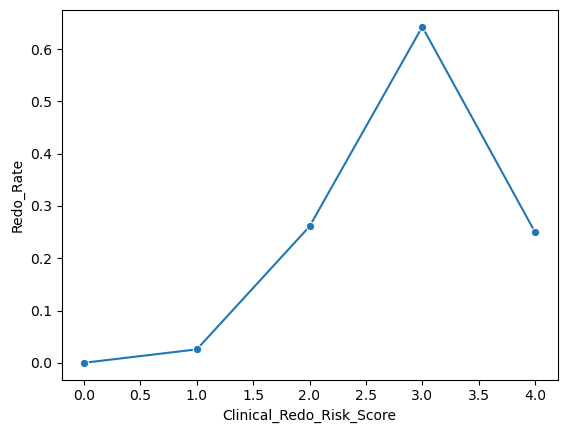

In [245]:
# Cross-tabulate score vs. observed outcome
score_table = pd.crosstab(data_with_ecg['Clinical_Redo_Risk_Score'], data_with_ecg['Redo_Ablation'])

# Plot observed risk
score_table['Redo_Rate'] = score_table[1] / (score_table[0] + score_table[1])
score_table.reset_index(inplace=True)

# Line plot of score vs. observed redo rate
sns.lineplot(data=score_table, x='Clinical_Redo_Risk_Score', y='Redo_Rate', marker='o')
plt.title

The redo rate starts near 0 at a risk score of 0, remains low until around 1.5, then sharply rises to a peak of about 0.6 at a risk score of 3.0. After this peak, the redo rate drops steeply to around 0.25 at a risk score of 3.5 and continues to decline slightly toward 4.0. The trend shows a strong increase in redo rate with higher risk scores up to 3.0, followed by a rapid decrease.

#### Scoring System: Change AF Duration and LAD 

In [249]:
# Define the updated scoring function with the new cutoffs
def calculate_clinical_risk_score(row):
    score = 0
    if row['Ablation1_PVI'] == 1:
        score += 1
    if row['AF_Duration_Months'] > 8:  # Updated cutoff
        score += 1
    if row['Echo_LAD'] <= 44:  # Updated cutoff
        score += 1
    if row['Age_at_Holter'] < 60:
        score += 1
    return score

# Apply to dataset with new cutoffs
data_with_ecg['Clinical_Redo_Risk_Score'] = data_with_ecg.apply(calculate_clinical_risk_score, axis=1)


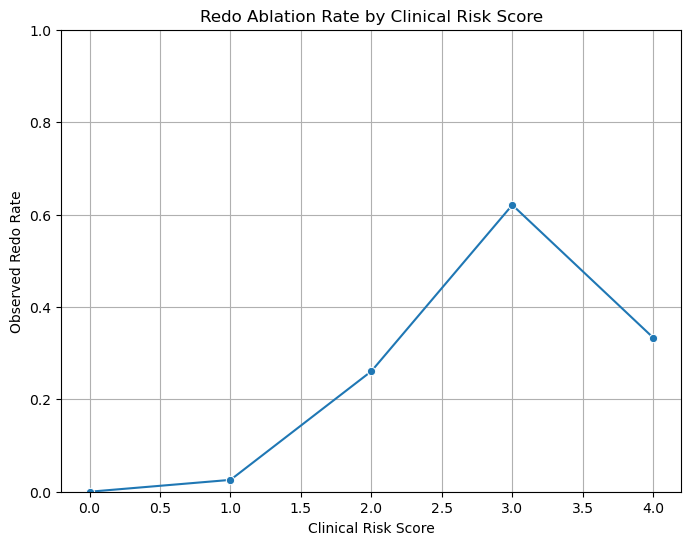

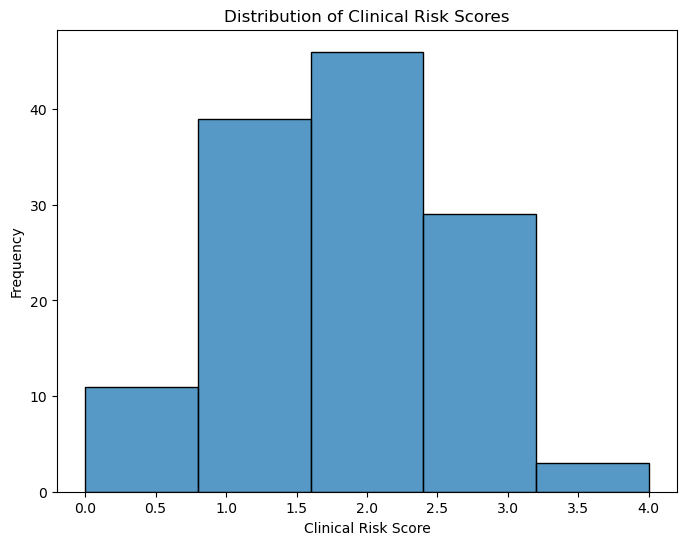

In [251]:
# Cross-tabulate the risk score vs the redo ablation outcome (0 or 1)
score_table = pd.crosstab(data_with_ecg['Clinical_Redo_Risk_Score'], data_with_ecg['Redo_Ablation'])

# Calculate redo ablation rate for each score
score_table['Redo_Rate'] = score_table[1] / (score_table[0] + score_table[1])
score_table.reset_index(inplace=True)

# Line plot of risk score vs redo rate
plt.figure(figsize=(8, 6))
sns.lineplot(data=score_table, x='Clinical_Redo_Risk_Score', y='Redo_Rate', marker='o')
plt.title("Redo Ablation Rate by Clinical Risk Score")
plt.ylabel("Observed Redo Rate")
plt.xlabel("Clinical Risk Score")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

# Histogram of Clinical Risk Scores
plt.figure(figsize=(8, 6))
sns.histplot(data_with_ecg['Clinical_Redo_Risk_Score'], kde=False, bins=5)
plt.title("Distribution of Clinical Risk Scores")
plt.xlabel("Clinical Risk Score")
plt.ylabel("Frequency")
plt.show()

No significant change int the scoring sytem output

#### Scoring System Adjust AF duration, change postive score for smaller LAD

In [255]:
# Define updated scoring function with the new interpretation for Echo LAD
def calculate_clinical_risk_score(row):
    score = 0
    if row['Ablation1_PVI'] == 1:
        score += 1
    if row['AF_Duration_Months'] > 8:  # Updated cutoff
        score += 1
    if row['Echo_LAD'] <= 44:  # Updated cutoff for Echo LAD
        score += 1  # Positive score for smaller LAD
    else:
        score -= 1  # Negative score for larger LAD
    if row['Age_at_Holter'] < 60:
        score += 1
    return score

# Apply to dataset with updated logic
data_with_ecg['Clinical_Redo_Risk_Score'] = data_with_ecg.apply(calculate_clinical_risk_score, axis=1)


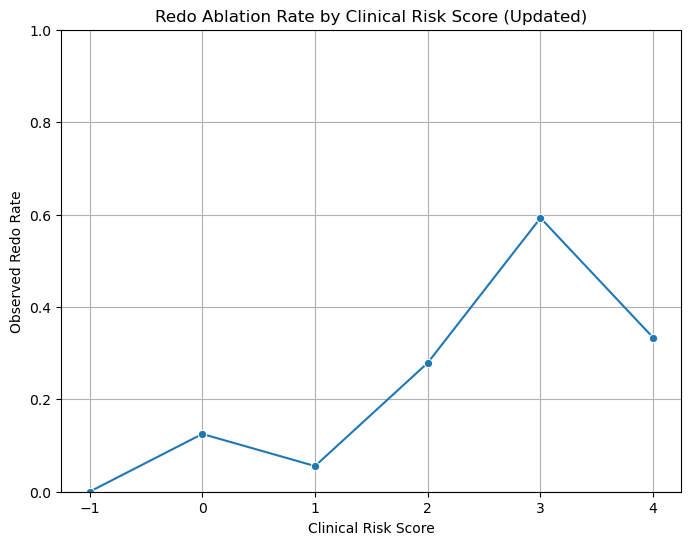

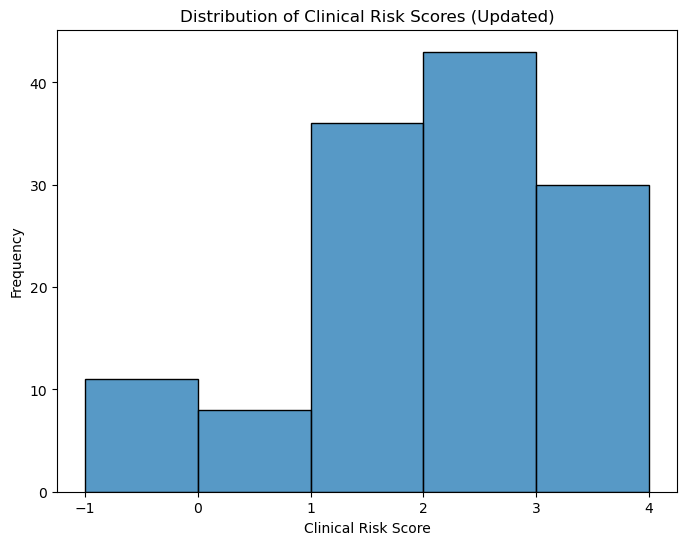

In [257]:
# Cross-tabulate the risk score vs the redo ablation outcome (0 or 1)
score_table = pd.crosstab(data_with_ecg['Clinical_Redo_Risk_Score'], data_with_ecg['Redo_Ablation'])

# Calculate redo ablation rate for each score
score_table['Redo_Rate'] = score_table[1] / (score_table[0] + score_table[1])
score_table.reset_index(inplace=True)

# Line plot of risk score vs redo rate
plt.figure(figsize=(8, 6))
sns.lineplot(data=score_table, x='Clinical_Redo_Risk_Score', y='Redo_Rate', marker='o')
plt.title("Redo Ablation Rate by Clinical Risk Score (Updated)")
plt.ylabel("Observed Redo Rate")
plt.xlabel("Clinical Risk Score")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

# Histogram of Clinical Risk Scores
plt.figure(figsize=(8, 6))
sns.histplot(data_with_ecg['Clinical_Redo_Risk_Score'], kde=False, bins=5)
plt.title("Distribution of Clinical Risk Scores (Updated)")
plt.xlabel("Clinical Risk Score")
plt.ylabel("Frequency")
plt.show()

The primary change is the extension of the x-axis to include negative risk scores, revealing a new early trend where the redo rate slightly increases and then dips before the sharp rise seen in the previous graph

#### Scoring sytem change thresholds for AF duration, age, and LAD

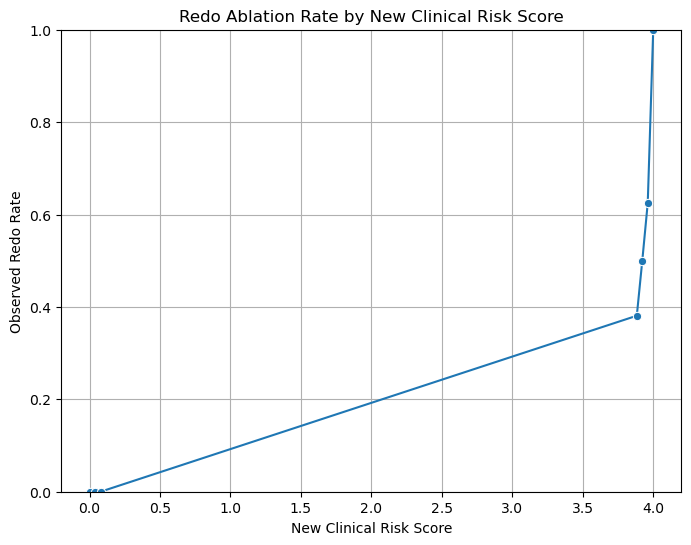

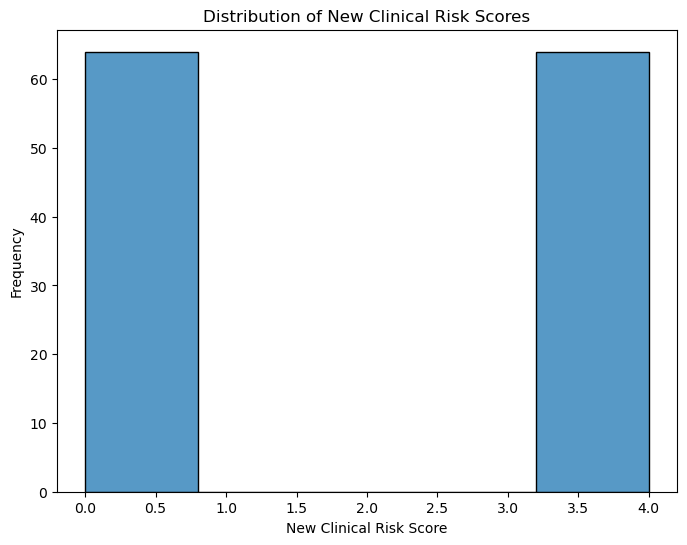

In [262]:
# Define thresholds for each feature (you can adjust these based on your data)
AF_DURATION_THRESHOLD = 24  # Median AF duration in months
ECHO_LAD_THRESHOLD = 40    # Median left atrial diameter in mm
AGE_THRESHOLD = 60         # Median age in years

# Calculate the raw clinical risk score based on the new system
data_with_ecg['New_Clinical_Redo_Risk_Score'] = (
    (data_with_ecg['Ablation1_PVI'] * 1.0) +  # +1 if present
    (data_with_ecg['AF_Duration_Months'] >= AF_DURATION_THRESHOLD).astype(int) * 0.01 +  # +0.01 if above threshold
    (data_with_ecg['Echo_LAD'] >= ECHO_LAD_THRESHOLD).astype(int) * (-0.01) +  # -0.01 if above threshold
    (data_with_ecg['Age_at_Holter'] >= AGE_THRESHOLD).astype(int) * (-0.01)  # -0.01 if above threshold
)

# Scale the scores to the 0–4 range
# Raw score range is -0.02 to 1.01, so shift by +0.02 and scale by 4/1.03
data_with_ecg['New_Clinical_Redo_Risk_Score'] = (data_with_ecg['New_Clinical_Redo_Risk_Score'] + 0.02) * (4 / 1.03)

# Cross-tabulate the new risk score vs the redo ablation outcome (0 or 1)
score_table = pd.crosstab(data_with_ecg['New_Clinical_Redo_Risk_Score'], data_with_ecg['Redo_Ablation'])

# Calculate redo ablation rate for each score
score_table['Redo_Rate'] = score_table[1] / (score_table[0] + score_table[1])
score_table.reset_index(inplace=True)

# Line plot of new risk score vs redo rate
plt.figure(figsize=(8, 6))
sns.lineplot(data=score_table, x='New_Clinical_Redo_Risk_Score', y='Redo_Rate', marker='o')
plt.title("Redo Ablation Rate by New Clinical Risk Score")
plt.ylabel("Observed Redo Rate")
plt.xlabel("New Clinical Risk Score")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

# Histogram of New Clinical Risk Scores
plt.figure(figsize=(8, 6))
sns.histplot(data_with_ecg['New_Clinical_Redo_Risk_Score'], kde=False, bins=5)
plt.title("Distribution of New Clinical Risk Scores")
plt.xlabel("New Clinical Risk Score")
plt.ylabel("Frequency")
plt.show()

The overall trend is now a smoother, more linear upward slope, indicating a more consistent increase in redo rate with higher risk scores, without the previous peak and decline

#### Scoring system change threshold, added correction factor

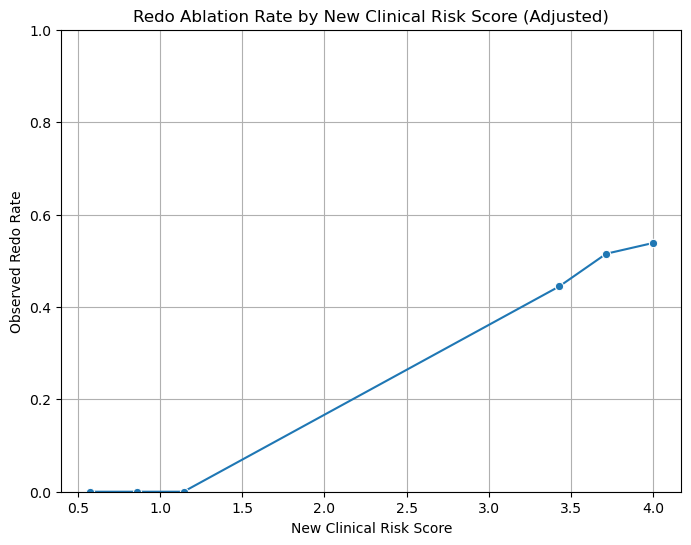

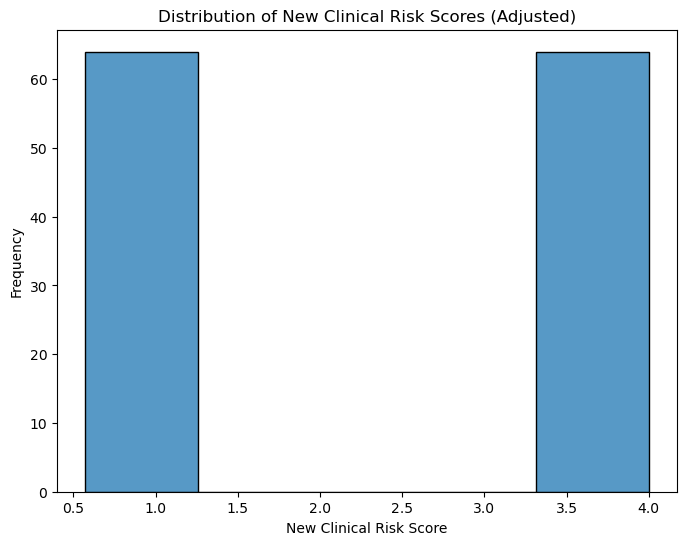

In [266]:
# Define thresholds (adjust these if needed)
AF_DURATION_THRESHOLD = data_with_ecg['AF_Duration_Months'].median()
ECHO_LAD_THRESHOLD = data_with_ecg['Echo_LAD'].median()
AGE_THRESHOLD = data_with_ecg['Age_at_Holter'].median()

# Calculate the raw clinical risk score with adjusted weights
data_with_ecg['New_Clinical_Redo_Risk_Score'] = (
    (data_with_ecg['Ablation1_PVI'] * 1.0) +  # +1 if present
    (data_with_ecg['AF_Duration_Months'] >= AF_DURATION_THRESHOLD).astype(int) * 0.2 +  # +0.2 if above threshold
    (data_with_ecg['Echo_LAD'] >= ECHO_LAD_THRESHOLD).astype(int) * (-0.1) +  # -0.1 if above threshold
    (data_with_ecg['Age_at_Holter'] >= AGE_THRESHOLD).astype(int) * (-0.1)  # -0.1 if above threshold
)

# Scale the scores to the 0–4 range
# Raw score range is -0.2 to 1.2, so shift by +0.2 and scale by 4/1.4
data_with_ecg['New_Clinical_Redo_Risk_Score'] = (data_with_ecg['New_Clinical_Redo_Risk_Score'] + 0.2) * (4 / 1.4)

# Cross-tabulate the new risk score vs the redo ablation outcome (0 or 1)
score_table = pd.crosstab(data_with_ecg['New_Clinical_Redo_Risk_Score'], data_with_ecg['Redo_Ablation'])

# Calculate redo ablation rate for each score
score_table['Redo_Rate'] = score_table[1] / (score_table[0] + score_table[1])
score_table.reset_index(inplace=True)

# Line plot of new risk score vs redo rate
plt.figure(figsize=(8, 6))
sns.lineplot(data=score_table, x='New_Clinical_Redo_Risk_Score', y='Redo_Rate', marker='o')
plt.title("Redo Ablation Rate by New Clinical Risk Score (Adjusted)")
plt.ylabel("Observed Redo Rate")
plt.xlabel("New Clinical Risk Score")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

# Histogram of New Clinical Risk Scores
plt.figure(figsize=(8, 6))
sns.histplot(data_with_ecg['New_Clinical_Redo_Risk_Score'], kde=False, bins=5)
plt.title("Distribution of New Clinical Risk Scores (Adjusted)")
plt.xlabel("New Clinical Risk Score")
plt.ylabel("Frequency")
plt.show()

Steady increase in redo rate with new clinical risk scores.

#### Scoring systen, change thresholds, change correction factor scale

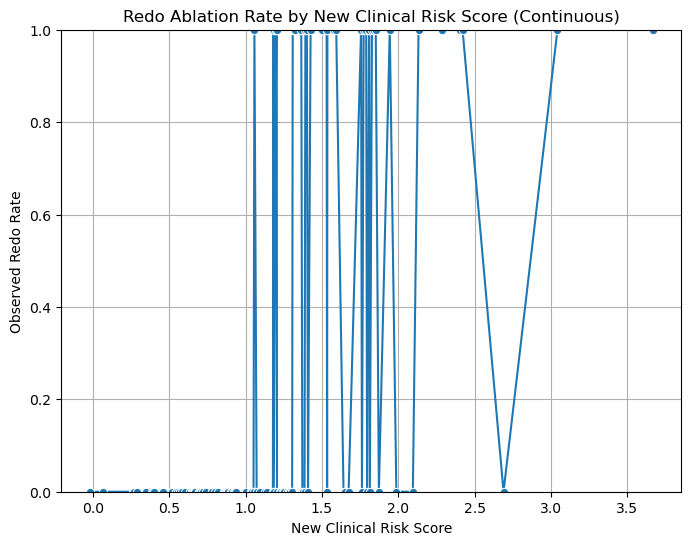

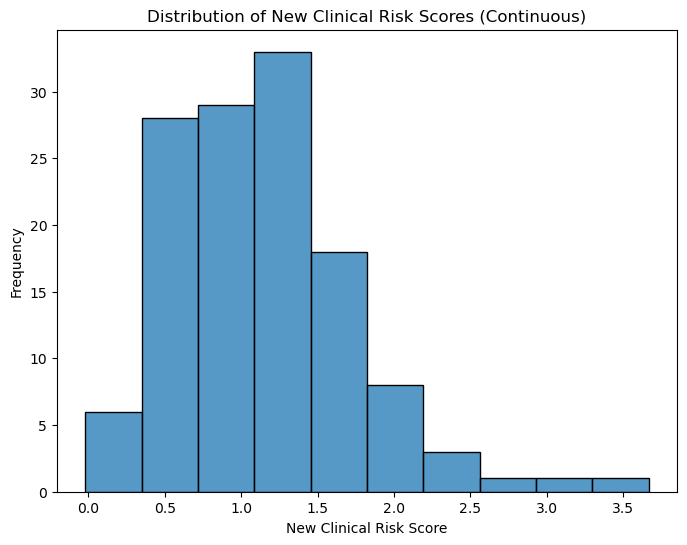

In [270]:
# Calculate the raw clinical risk score using continuous values
data_with_ecg['New_Clinical_Redo_Risk_Score'] = (
    (data_with_ecg['Ablation1_PVI'] * 1.0) +  # +1 if present
    (data_with_ecg['AF_Duration_Months'] * 0.023) +  # +0.023 per month
    (data_with_ecg['Echo_LAD'] * (-0.039)) +  # -0.039 per mm
    (data_with_ecg['Age_at_Holter'] * (-0.018))  # -0.018 per year
)

# Scale the scores to the 0–4 range
# Raw score range is -3.78 to 2.44, so shift by +3.78 and scale by 4/6.22
data_with_ecg['New_Clinical_Redo_Risk_Score'] = (data_with_ecg['New_Clinical_Redo_Risk_Score'] + 3.78) * (4 / 6.22)

# Cross-tabulate the new risk score vs the redo ablation outcome (0 or 1)
score_table = pd.crosstab(data_with_ecg['New_Clinical_Redo_Risk_Score'], data_with_ecg['Redo_Ablation'])

# Calculate redo ablation rate for each score
score_table['Redo_Rate'] = score_table[1] / (score_table[0] + score_table[1])
score_table.reset_index(inplace=True)

# Line plot of new risk score vs redo rate
plt.figure(figsize=(8, 6))
sns.lineplot(data=score_table, x='New_Clinical_Redo_Risk_Score', y='Redo_Rate', marker='o')
plt.title("Redo Ablation Rate by New Clinical Risk Score (Continuous)")
plt.ylabel("Observed Redo Rate")
plt.xlabel("New Clinical Risk Score")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

# Histogram of New Clinical Risk Scores
plt.figure(figsize=(8, 6))
sns.histplot(data_with_ecg['New_Clinical_Redo_Risk_Score'], kde=False, bins=10)  # Increased bins for more detail
plt.title("Distribution of New Clinical Risk Scores (Continuous)")
plt.xlabel("New Clinical Risk Score")
plt.ylabel("Frequency")
plt.show()

a dense cluster of redo rates (~0.9) between risk scores 1.0 and 2.0, and a V-shaped trend dipping to ~0.1 at a risk score of 3.0 before rising again toward 4.0, replacing the previous single-line upward trend.

#### Scoring system change, using medians

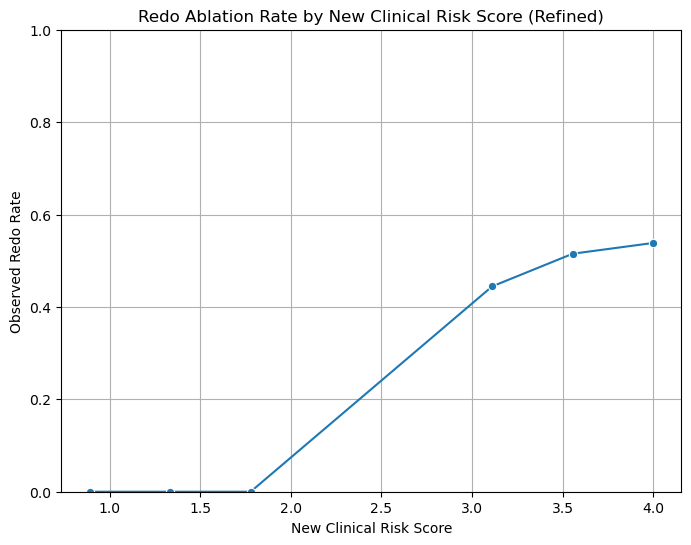

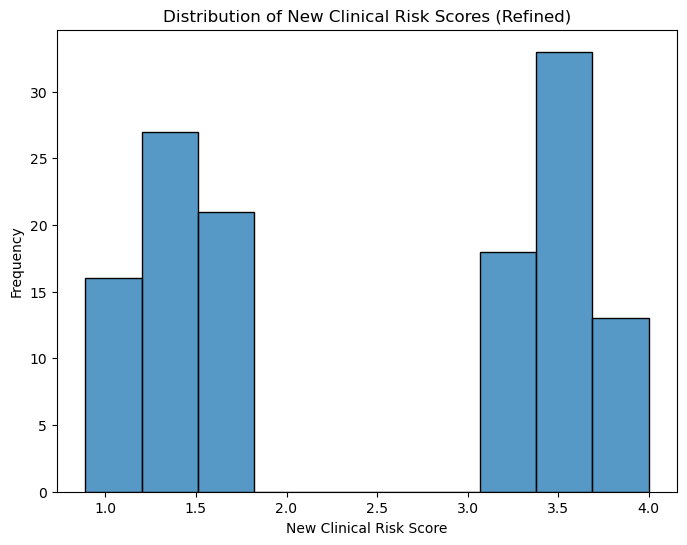

In [274]:
# Define thresholds (using medians for accuracy)
AF_DURATION_THRESHOLD = data_with_ecg['AF_Duration_Months'].median()
ECHO_LAD_THRESHOLD = data_with_ecg['Echo_LAD'].median()
AGE_THRESHOLD = data_with_ecg['Age_at_Holter'].median()

# Calculate the raw clinical risk score with refined weights
data_with_ecg['New_Clinical_Redo_Risk_Score'] = (
    (data_with_ecg['Ablation1_PVI'] * 1.0) +  # +1 if present
    (data_with_ecg['AF_Duration_Months'] >= AF_DURATION_THRESHOLD).astype(int) * 0.4 +  # +0.4 if above threshold
    (data_with_ecg['Echo_LAD'] >= ECHO_LAD_THRESHOLD).astype(int) * (-0.2) +  # -0.2 if above threshold
    (data_with_ecg['Age_at_Holter'] >= AGE_THRESHOLD).astype(int) * (-0.2)  # -0.2 if above threshold
)

# Scale the scores to the 0–4 range
# Raw score range is -0.4 to 1.4, so shift by +0.4 and scale by 4/1.8
data_with_ecg['New_Clinical_Redo_Risk_Score'] = (data_with_ecg['New_Clinical_Redo_Risk_Score'] + 0.4) * (4 / 1.8)

# Cross-tabulate the new risk score vs the redo ablation outcome (0 or 1)
score_table = pd.crosstab(data_with_ecg['New_Clinical_Redo_Risk_Score'], data_with_ecg['Redo_Ablation'])

# Calculate redo ablation rate for each score
score_table['Redo_Rate'] = score_table[1] / (score_table[0] + score_table[1])
score_table.reset_index(inplace=True)

# Line plot of new risk score vs redo rate
plt.figure(figsize=(8, 6))
sns.lineplot(data=score_table, x='New_Clinical_Redo_Risk_Score', y='Redo_Rate', marker='o')
plt.title("Redo Ablation Rate by New Clinical Risk Score (Refined)")
plt.ylabel("Observed Redo Rate")
plt.xlabel("New Clinical Risk Score")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

# Histogram of New Clinical Risk Scores
plt.figure(figsize=(8, 6))
sns.histplot(data_with_ecg['New_Clinical_Redo_Risk_Score'], kde=False, bins=10)  # Increased bins for more detail
plt.title("Distribution of New Clinical Risk Scores (Refined)")
plt.xlabel("New Clinical Risk Score")
plt.ylabel("Frequency")
plt.show()

a steady increase in redo rate from ~0 at a risk score of 0.5 to ~0.7 at a risk score of 4.0, with no dips or peaks

In [277]:
# Calculate the median thresholds and print them
AF_DURATION_THRESHOLD = data_with_ecg['AF_Duration_Months'].median()
ECHO_LAD_THRESHOLD = data_with_ecg['Echo_LAD'].median()
AGE_THRESHOLD = data_with_ecg['Age_at_Holter'].median()

# Print the thresholds
print(f"AF_Duration_Months Threshold (median): {AF_DURATION_THRESHOLD} months")
print(f"Echo_LAD Threshold (median): {ECHO_LAD_THRESHOLD} mm")
print(f"Age_at_Holter Threshold (median): {AGE_THRESHOLD} years")

# Calculate the raw clinical risk score with refined weights
data_with_ecg['New_Clinical_Redo_Risk_Score'] = (
    (data_with_ecg['Ablation1_PVI'] * 1.0) +  # +1 if present
    (data_with_ecg['AF_Duration_Months'] >= AF_DURATION_THRESHOLD).astype(int) * 0.4 +  # +0.4 if above threshold
    (data_with_ecg['Echo_LAD'] >= ECHO_LAD_THRESHOLD).astype(int) * (-0.2) +  # -0.2 if above threshold
    (data_with_ecg['Age_at_Holter'] >= AGE_THRESHOLD).astype(int) * (-0.2)  # -0.2 if above threshold
)

# Scale the scores to the 0–4 range
data_with_ecg['New_Clinical_Redo_Risk_Score'] = (data_with_ecg['New_Clinical_Redo_Risk_Score'] + 0.4) * (4 / 1.8)


AF_Duration_Months Threshold (median): 0.0 months
Echo_LAD Threshold (median): 39.304 mm
Age_at_Holter Threshold (median): 67.5 years


#### Scoring System Change, Define Fixed Thresholds, Add PVI

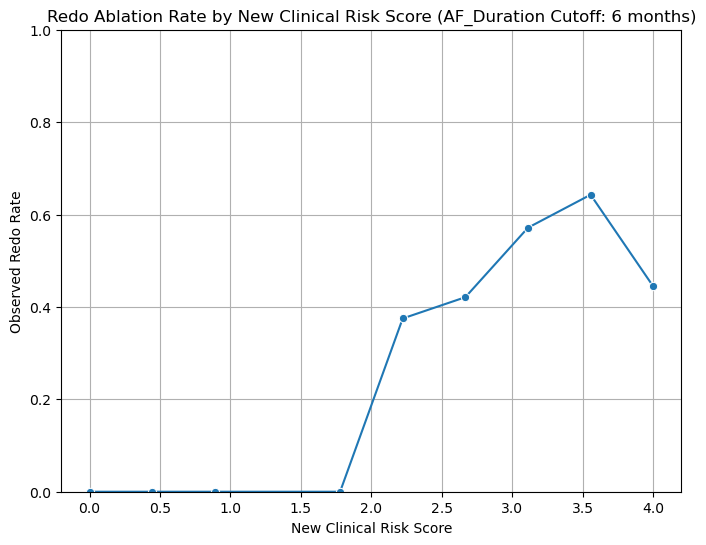

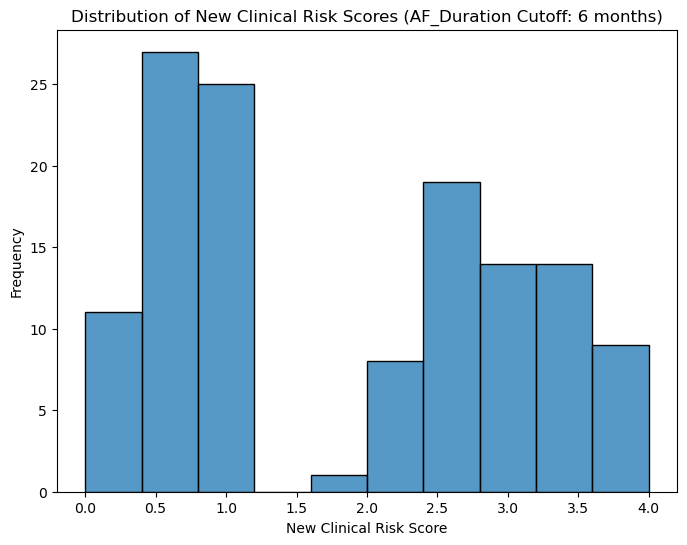

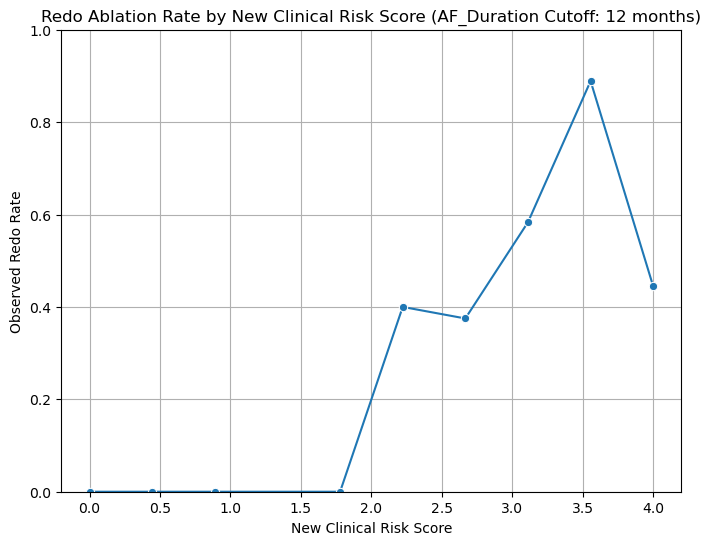

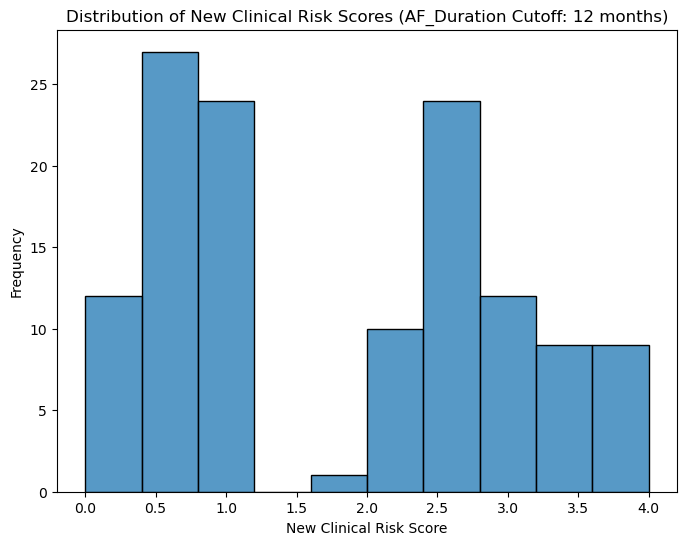

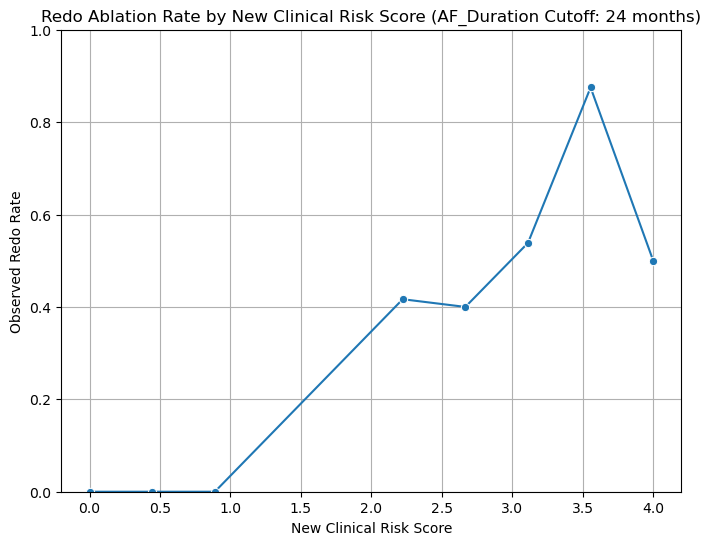

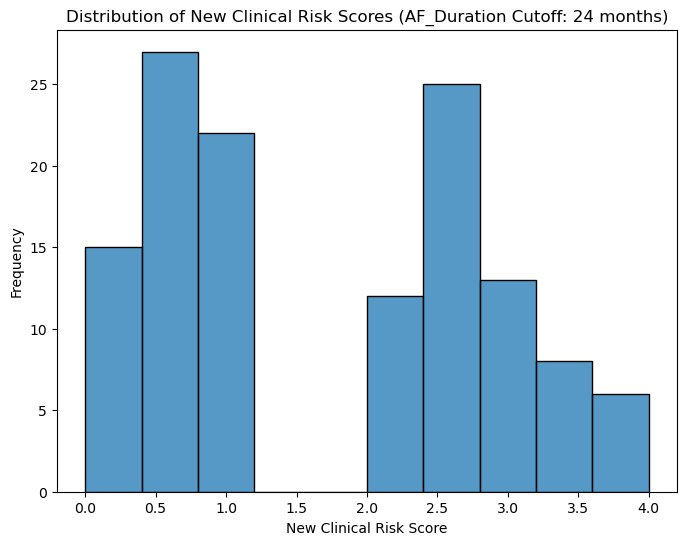

In [280]:
# Define the fixed thresholds for Echo_LAD and Age_at_Holter
ECHO_LAD_THRESHOLD = 39.304  # mm
AGE_THRESHOLD = 67.5  # years

# List of AF_Duration_Months cutoffs to test
AF_DURATION_CUTOFFS = [6, 12, 24]

# Loop through each cutoff and generate plots
for cutoff in AF_DURATION_CUTOFFS:
    # Calculate the raw clinical risk score with the current AF_Duration_Months cutoff
    data_with_ecg['New_Clinical_Redo_Risk_Score'] = (
        (data_with_ecg['Ablation1_PVI'] * 1.0) +  # +1 if present
        (data_with_ecg['AF_Duration_Months'] >= cutoff).astype(int) * 0.4 +  # +0.4 if above cutoff
        (data_with_ecg['Echo_LAD'] >= ECHO_LAD_THRESHOLD).astype(int) * (-0.2) +  # -0.2 if above threshold
        (data_with_ecg['Age_at_Holter'] >= AGE_THRESHOLD).astype(int) * (-0.2)  # -0.2 if above threshold
    )

    # Scale the scores to the 0–4 range
    # Raw score range is -0.4 to 1.4, so shift by +0.4 and scale by 4/1.8
    data_with_ecg['New_Clinical_Redo_Risk_Score'] = (data_with_ecg['New_Clinical_Redo_Risk_Score'] + 0.4) * (4 / 1.8)

    # Cross-tabulate the new risk score vs the redo ablation outcome (0 or 1)
    score_table = pd.crosstab(data_with_ecg['New_Clinical_Redo_Risk_Score'], data_with_ecg['Redo_Ablation'])

    # Calculate redo ablation rate for each score
    score_table['Redo_Rate'] = score_table[1] / (score_table[0] + score_table[1])
    score_table.reset_index(inplace=True)

    # Line plot of new risk score vs redo rate
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=score_table, x='New_Clinical_Redo_Risk_Score', y='Redo_Rate', marker='o')
    plt.title(f"Redo Ablation Rate by New Clinical Risk Score (AF_Duration Cutoff: {cutoff} months)")
    plt.ylabel("Observed Redo Rate")
    plt.xlabel("New Clinical Risk Score")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.show()

    # Histogram of New Clinical Risk Scores
    plt.figure(figsize=(8, 6))
    sns.histplot(data_with_ecg['New_Clinical_Redo_Risk_Score'], kde=False, bins=10)
    plt.title(f"Distribution of New Clinical Risk Scores (AF_Duration Cutoff: {cutoff} months)")
    plt.xlabel("New Clinical Risk Score")
    plt.ylabel("Frequency")
    plt.show()

The redo rate rises sharply from ~0 at a risk score of 1.5 to a peak of ~0.65 at a risk score of 3.0, then drops to ~0.45 at a risk score of 3.5, with a slight decline toward 4.0. AF duration of 12 months appears to be the best cutoff. 

#### Scoring System Changes, Revert to 12 month cutoff, Obtain Correlation Data

Point-Biserial Correlation Coefficient: 0.584
P-value (Point-Biserial): 0.000
AUC-ROC: 0.871
Spearman Rank Correlation Coefficient (Redo Rate vs. Binned Risk Scores): 0.888
P-value (Spearman): 0.001


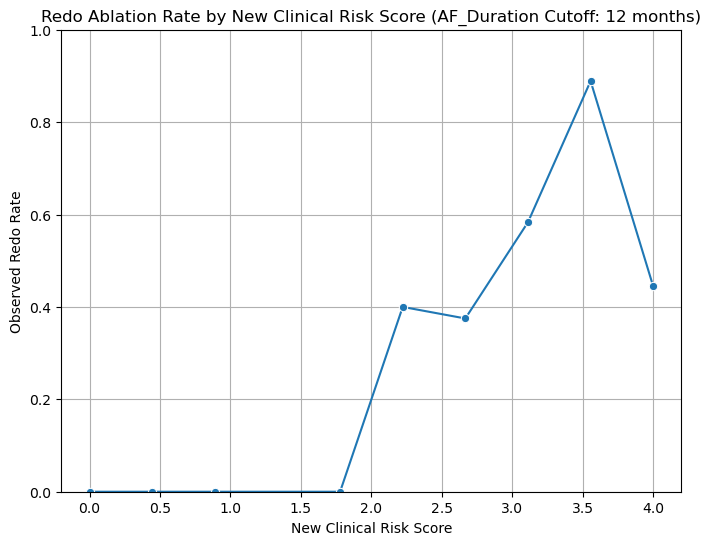

In [295]:
# Calculate the risk scores with the 12-month cutoff
# Define the thresholds
AF_DURATION_CUTOFF = 12  # months
ECHO_LAD_THRESHOLD = 39.304  # mm
AGE_THRESHOLD = 67.5  # years

# Calculate the raw clinical risk score
data_with_ecg['New_Clinical_Redo_Risk_Score'] = (
    (data_with_ecg['Ablation1_PVI'] * 1.0) +  # +1 if present
    (data_with_ecg['AF_Duration_Months'] >= AF_DURATION_CUTOFF).astype(int) * 0.4 +  # +0.4 if above cutoff
    (data_with_ecg['Echo_LAD'] >= ECHO_LAD_THRESHOLD).astype(int) * (-0.2) +  # -0.2 if above threshold
    (data_with_ecg['Age_at_Holter'] >= AGE_THRESHOLD).astype(int) * (-0.2)  # -0.2 if above threshold
)

# Scale the scores to the 0–4 range
data_with_ecg['New_Clinical_Redo_Risk_Score'] = (data_with_ecg['New_Clinical_Redo_Risk_Score'] + 0.4) * (4 / 1.8)

#  Point-Biserial Correlation
# Calculate the point-biserial correlation between the risk score and the binary redo ablation outcome
point_biserial_corr, p_value_pb = pointbiserialr(data_with_ecg['New_Clinical_Redo_Risk_Score'], data_with_ecg['Redo_Ablation'])
print(f"Point-Biserial Correlation Coefficient: {point_biserial_corr:.3f}")
print(f"P-value (Point-Biserial): {p_value_pb:.3f}")

# AUC-ROC
# Calculate the AUC-ROC score to evaluate the discriminative ability of the risk score
auc_roc = roc_auc_score(data_with_ecg['Redo_Ablation'], data_with_ecg['New_Clinical_Redo_Risk_Score'])
print(f"AUC-ROC: {auc_roc:.3f}")

# Spearman Rank Correlation (Redo Rate vs. Binned Risk Scores)
# Bin the risk scores and calculate the redo rate for each bin (as done in the line plot)
# Cross-tabulate the new risk score vs the redo ablation outcome (0 or 1)
score_table = pd.crosstab(data_with_ecg['New_Clinical_Redo_Risk_Score'], data_with_ecg['Redo_Ablation'])

# Calculate redo ablation rate for each score
score_table['Redo_Rate'] = score_table[1] / (score_table[0] + score_table[1])
score_table.reset_index(inplace=True)

# Spearman correlation between the binned risk scores and the redo rates
spearman_corr, p_value_spearman = spearmanr(score_table['New_Clinical_Redo_Risk_Score'], score_table['Redo_Rate'])
print(f"Spearman Rank Correlation Coefficient (Redo Rate vs. Binned Risk Scores): {spearman_corr:.3f}")
print(f"P-value (Spearman): {p_value_spearman:.3f}")

# Step 5: Re-generate the redo ablation rate plot for reference
plt.figure(figsize=(8, 6))
sns.lineplot(data=score_table, x='New_Clinical_Redo_Risk_Score', y='Redo_Rate', marker='o')
plt.title(f"Redo Ablation Rate by New Clinical Risk Score (AF_Duration Cutoff: {AF_DURATION_CUTOFF} months)")
plt.ylabel("Observed Redo Rate")
plt.xlabel("New Clinical Risk Score")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

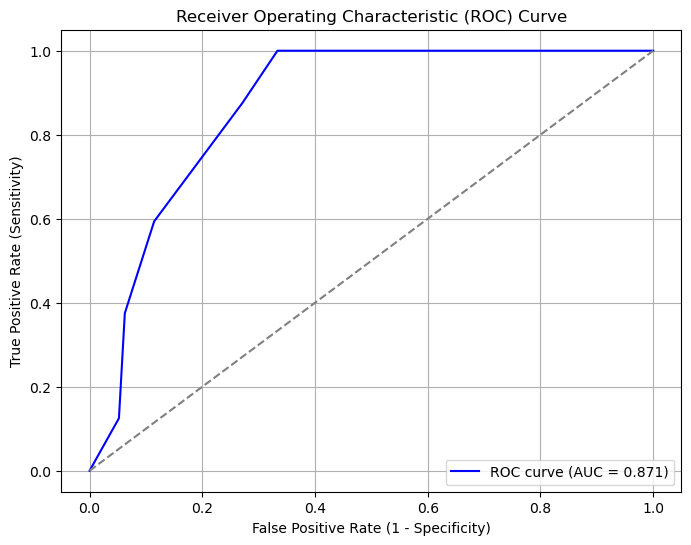

Optimal Threshold (maximizing Youden's J): 2.222
Sensitivity at Optimal Threshold: 1.000
Specificity at Optimal Threshold: 0.667
Positive Predictive Value (PPV): 0.500
Negative Predictive Value (NPV): 1.000


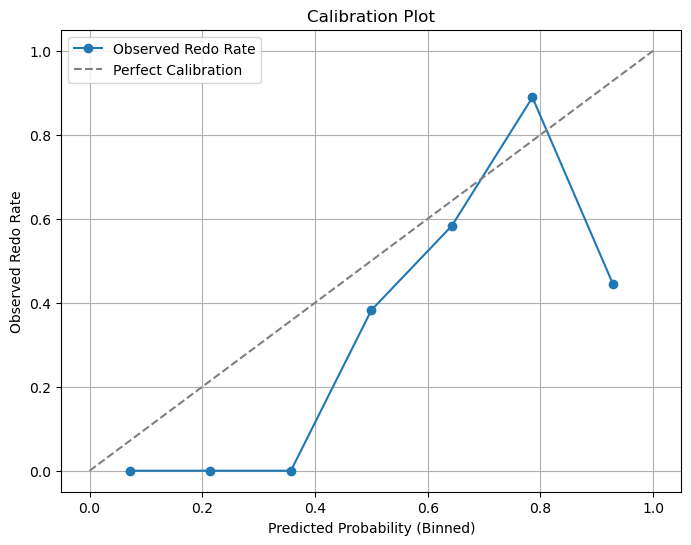

Hosmer-Lemeshow Statistic: 29.652
Degrees of Freedom: 5
P-value (Hosmer-Lemeshow): 0.000
Brier Score: 0.166


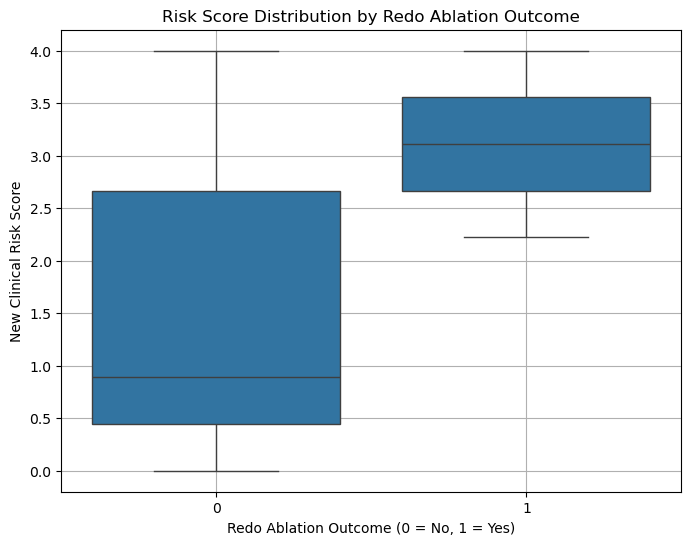

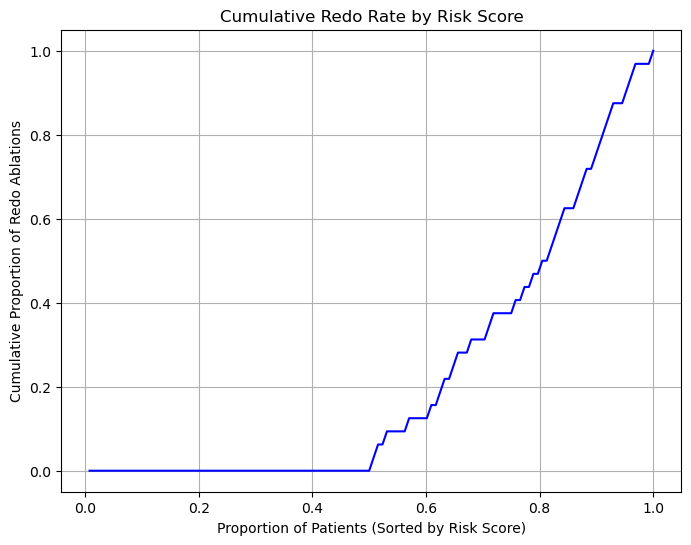


Risk Stratification Table:
         Risk Category  Number of Patients  Redo Rate
0     Low Risk (0-1.5)                  63   0.000000
1  Medium Risk (1.5-3)                  35   0.371429
2      High Risk (3-4)                  30   0.633333


In [305]:
# Ensure the risk scores are calculated (using the 12-month cutoff)
AF_DURATION_CUTOFF = 12  # months
ECHO_LAD_THRESHOLD = 39.304  # mm
AGE_THRESHOLD = 67.5  # years

data_with_ecg['New_Clinical_Redo_Risk_Score'] = (
    (data_with_ecg['Ablation1_PVI'] * 1.0) +
    (data_with_ecg['AF_Duration_Months'] >= AF_DURATION_CUTOFF).astype(int) * 0.4 +
    (data_with_ecg['Echo_LAD'] >= ECHO_LAD_THRESHOLD).astype(int) * (-0.2) +
    (data_with_ecg['Age_at_Holter'] >= AGE_THRESHOLD).astype(int) * (-0.2)
)
data_with_ecg['New_Clinical_Redo_Risk_Score'] = (data_with_ecg['New_Clinical_Redo_Risk_Score'] + 0.4) * (4 / 1.8)

# ROC Curve Plot
fpr, tpr, thresholds = roc_curve(data_with_ecg['Redo_Ablation'], data_with_ecg['New_Clinical_Redo_Risk_Score'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Find the optimal threshold (maximizing Youden's J statistic: sensitivity + specificity - 1)
youden_j = tpr - fpr
optimal_idx = np.argmax(youden_j)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold (maximizing Youden's J): {optimal_threshold:.3f}")

# Sensitivity, Specificity, PPV, and NPV at the Optimal Threshold
predictions = (data_with_ecg['New_Clinical_Redo_Risk_Score'] >= optimal_threshold).astype(int)
true_positives = np.sum((predictions == 1) & (data_with_ecg['Redo_Ablation'] == 1))
false_positives = np.sum((predictions == 1) & (data_with_ecg['Redo_Ablation'] == 0))
true_negatives = np.sum((predictions == 0) & (data_with_ecg['Redo_Ablation'] == 0))
false_negatives = np.sum((predictions == 0) & (data_with_ecg['Redo_Ablation'] == 1))

sensitivity = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
specificity = true_negatives / (true_negatives + false_positives) if (true_negatives + false_positives) > 0 else 0
ppv = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
npv = true_negatives / (true_negatives + false_negatives) if (true_negatives + false_negatives) > 0 else 0

print(f"Sensitivity at Optimal Threshold: {sensitivity:.3f}")
print(f"Specificity at Optimal Threshold: {specificity:.3f}")
print(f"Positive Predictive Value (PPV): {ppv:.3f}")
print(f"Negative Predictive Value (NPV): {npv:.3f}")

# Calibration Plot
# Bin the risk scores into 10 equal-sized bins and calculate observed redo rates
data_with_ecg['Score_Bin'] = pd.qcut(data_with_ecg['New_Clinical_Redo_Risk_Score'], q=10, duplicates='drop')
calibration_data = data_with_ecg.groupby('Score_Bin', observed=True)['Redo_Ablation'].mean().reset_index()
calibration_data['Predicted_Probability'] = (calibration_data.index + 0.5) / len(calibration_data)  # Adjusted for number of bins

plt.figure(figsize=(8, 6))
plt.plot(calibration_data['Predicted_Probability'], calibration_data['Redo_Ablation'], marker='o', label='Observed Redo Rate')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Perfect Calibration')
plt.xlabel('Predicted Probability (Binned)')
plt.ylabel('Observed Redo Rate')
plt.title('Calibration Plot')
plt.legend()
plt.grid(True)
plt.show()

# Hosmer-Lemeshow Test for Calibration
# Group into bins and calculate observed vs. expected redo rates
hl_data = data_with_ecg.groupby('Score_Bin', observed=True).agg({
    'Redo_Ablation': ['sum', 'count']
}).reset_index()
hl_data.columns = ['Score_Bin', 'Observed_Redo', 'Total']
hl_data['Expected_Redo'] = hl_data['Total'] * (hl_data.index + 0.5) / len(hl_data)  # Adjusted for number of bins
hl_data['Observed_Non_Redo'] = hl_data['Total'] - hl_data['Observed_Redo']
hl_data['Expected_Non_Redo'] = hl_data['Total'] - hl_data['Expected_Redo']

# Add a small continuity correction to avoid zero expected frequencies
continuity_correction = 0.5
hl_data['Expected_Redo'] = hl_data['Expected_Redo'] + continuity_correction
hl_data['Expected_Non_Redo'] = hl_data['Expected_Non_Redo'] + continuity_correction

# Perform Hosmer-Lemeshow test (manual chi-squared calculation)
hl_statistic = 0
for i in range(len(hl_data)):
    if hl_data['Expected_Redo'][i] > 0 and hl_data['Expected_Non_Redo'][i] > 0:
        hl_statistic += (hl_data['Observed_Redo'][i] - hl_data['Expected_Redo'][i])**2 / hl_data['Expected_Redo'][i]
        hl_statistic += (hl_data['Observed_Non_Redo'][i] - hl_data['Expected_Non_Redo'][i])**2 / hl_data['Expected_Non_Redo'][i]

degrees_of_freedom = len(hl_data) - 2
p_value_hl = 1 - chi2.cdf(hl_statistic, degrees_of_freedom) if degrees_of_freedom > 0 else 1.0
print(f"Hosmer-Lemeshow Statistic: {hl_statistic:.3f}")
print(f"Degrees of Freedom: {degrees_of_freedom}")
print(f"P-value (Hosmer-Lemeshow): {p_value_hl:.3f}")

# Step 5: Brier Score
# Map risk scores to predicted probabilities (scale to 0-1)
predicted_probs = data_with_ecg['New_Clinical_Redo_Risk_Score'] / 4.0  # Scale to 0-1
brier = brier_score_loss(data_with_ecg['Redo_Ablation'], predicted_probs)
print(f"Brier Score: {brier:.3f}")

# Step 6: Box Plot of Risk Scores by Redo Ablation Outcome
plt.figure(figsize=(8, 6))
sns.boxplot(x='Redo_Ablation', y='New_Clinical_Redo_Risk_Score', data=data_with_ecg)
plt.xlabel('Redo Ablation Outcome (0 = No, 1 = Yes)')
plt.ylabel('New Clinical Risk Score')
plt.title('Risk Score Distribution by Redo Ablation Outcome')
plt.grid(True)
plt.show()

# umulative Redo Rate Plot
# Sort patients by risk score and calculate cumulative redo rate
sorted_data = data_with_ecg.sort_values('New_Clinical_Redo_Risk_Score')
cumulative_redo = sorted_data['Redo_Ablation'].cumsum() / sorted_data['Redo_Ablation'].sum()
cumulative_proportion = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

plt.figure(figsize=(8, 6))
plt.plot(cumulative_proportion, cumulative_redo, color='blue')
plt.xlabel('Proportion of Patients (Sorted by Risk Score)')
plt.ylabel('Cumulative Proportion of Redo Ablations')
plt.title('Cumulative Redo Rate by Risk Score')
plt.grid(True)
plt.show()

# Risk Stratification Table
# Define risk categories (e.g., Low: 0-1.5, Medium: 1.5-3, High: 3-4)
bins = [0, 1.5, 3, 4]
labels = ['Low Risk (0-1.5)', 'Medium Risk (1.5-3)', 'High Risk (3-4)']
data_with_ecg['Risk_Category'] = pd.cut(data_with_ecg['New_Clinical_Redo_Risk_Score'], bins=bins, labels=labels, include_lowest=True)
strat_table = data_with_ecg.groupby('Risk_Category', observed=True)['Redo_Ablation'].agg(['count', 'mean']).reset_index()
strat_table.columns = ['Risk Category', 'Number of Patients', 'Redo Rate']
print("\nRisk Stratification Table:")
print(strat_table)

Good separation between Low, med, and high risk. 

#### Scoring System, Adjust Weights to Remove the Correction Factor

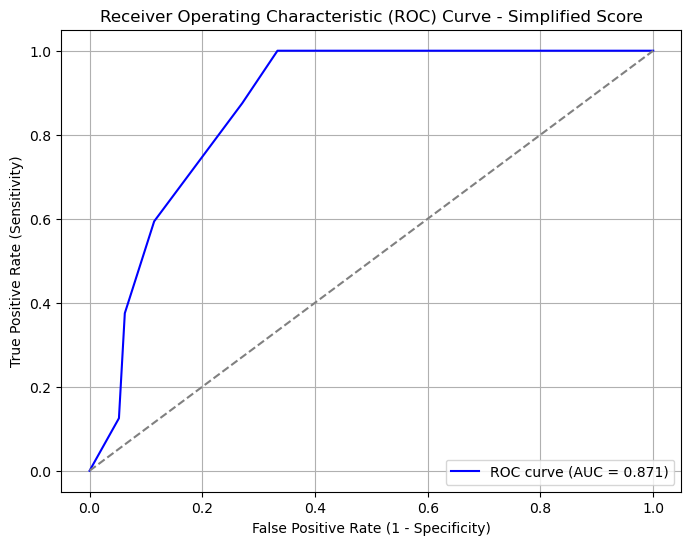

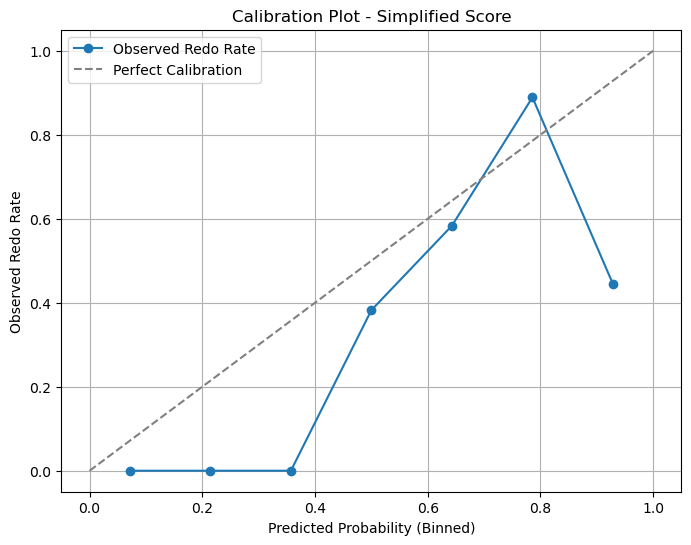

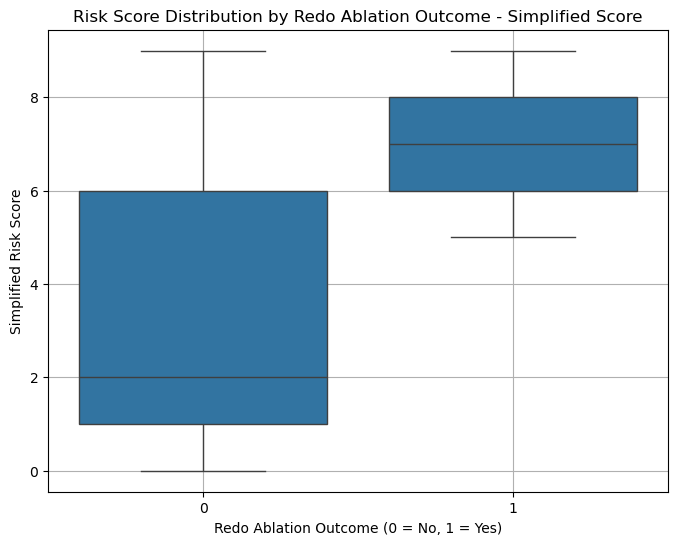

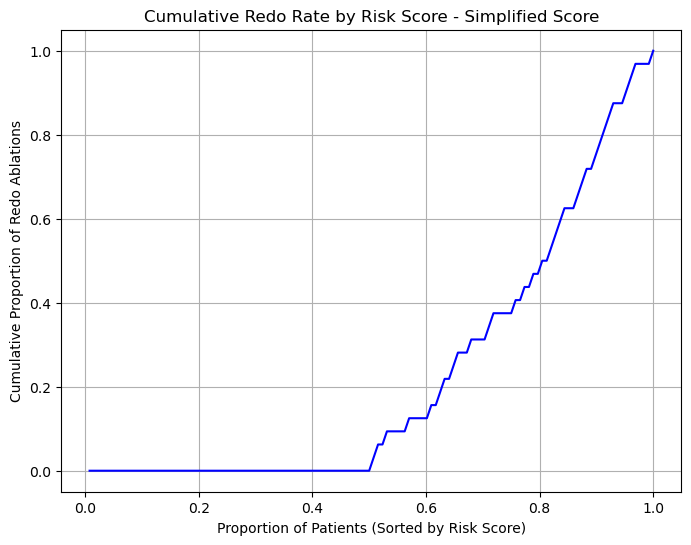


Simplified Risk Stratification Table:
       Risk Category  Number of Patients  Redo Rate
0     Low Risk (0-3)                  63   0.000000
1  Medium Risk (4-6)                  35   0.371429
2    High Risk (7-9)                  30   0.633333


In [311]:


# Define thresholds (same as original)
AF_DURATION_CUTOFF = 12  # months
ECHO_LAD_THRESHOLD = 39.304  # mm
AGE_THRESHOLD = 67.5  # years

# Calculate Simplified Risk Score using the actual data_with_ecg DataFrame
# Simplified scoring system: Start with 2, add/subtract whole numbers
data_with_ecg['Simplified_Risk_Score'] = (
    2 +  # Base score
    (data_with_ecg['Ablation1_PVI'] * 5) +  # +5 if Ablation1_PVI = 1
    ((data_with_ecg['AF_Duration_Months'] >= AF_DURATION_CUTOFF).astype(int) * 2) +  # +2 if AF_Duration >= 12
    ((data_with_ecg['Echo_LAD'] >= ECHO_LAD_THRESHOLD).astype(int) * (-1)) +  # -1 if Echo_LAD >= 39.304
    ((data_with_ecg['Age_at_Holter'] >= AGE_THRESHOLD).astype(int) * (-1))  # -1 if Age_at_Holter >= 67.5
)

# Plot 1: ROC Curve Plot
fpr, tpr, thresholds = roc_curve(data_with_ecg['Redo_Ablation'], data_with_ecg['Simplified_Risk_Score'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve - Simplified Score')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot 2: Calibration Plot
# Bin the risk scores into 10 equal-sized bins and calculate observed redo rates
data_with_ecg['Score_Bin'] = pd.qcut(data_with_ecg['Simplified_Risk_Score'], q=10, duplicates='drop')
calibration_data = data_with_ecg.groupby('Score_Bin', observed=True)['Redo_Ablation'].mean().reset_index()
calibration_data['Predicted_Probability'] = (calibration_data.index + 0.5) / len(calibration_data)

plt.figure(figsize=(8, 6))
plt.plot(calibration_data['Predicted_Probability'], calibration_data['Redo_Ablation'], marker='o', label='Observed Redo Rate')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Perfect Calibration')
plt.xlabel('Predicted Probability (Binned)')
plt.ylabel('Observed Redo Rate')
plt.title('Calibration Plot - Simplified Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot 3: Box Plot of Risk Scores by Redo Ablation Outcome
plt.figure(figsize=(8, 6))
sns.boxplot(x='Redo_Ablation', y='Simplified_Risk_Score', data=data_with_ecg)
plt.xlabel('Redo Ablation Outcome (0 = No, 1 = Yes)')
plt.ylabel('Simplified Risk Score')
plt.title('Risk Score Distribution by Redo Ablation Outcome - Simplified Score')
plt.grid(True)
plt.show()

# Plot 4: Cumulative Redo Rate Plot
# Sort patients by risk score and calculate cumulative redo rate
sorted_data = data_with_ecg.sort_values('Simplified_Risk_Score')
cumulative_redo = sorted_data['Redo_Ablation'].cumsum() / sorted_data['Redo_Ablation'].sum()
cumulative_proportion = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

plt.figure(figsize=(8, 6))
plt.plot(cumulative_proportion, cumulative_redo, color='blue')
plt.xlabel('Proportion of Patients (Sorted by Risk Score)')
plt.ylabel('Cumulative Proportion of Redo Ablations')
plt.title('Cumulative Redo Rate by Risk Score - Simplified Score')
plt.grid(True)
plt.show()

# Risk Stratification Table
bins = [0, 3, 6, 9]  # Adjusted for new range (0 to 9)
labels = ['Low Risk (0-3)', 'Medium Risk (4-6)', 'High Risk (7-9)']
data_with_ecg['Risk_Category'] = pd.cut(data_with_ecg['Simplified_Risk_Score'], bins=bins, labels=labels, include_lowest=True)
strat_table = data_with_ecg.groupby('Risk_Category', observed=True)['Redo_Ablation'].agg(['count', 'mean']).reset_index()
strat_table.columns = ['Risk Category', 'Number of Patients', 'Redo Rate']
print("\nSimplified Risk Stratification Table:")
print(strat_table)

In [313]:
# Table 1: Original Scoring System
original_data = [
    {"Variable": "Previous Pulmonary Vein Ablation", "Condition": "Present", "Action": "Add 1.0"},
    {"Variable": "Atrial Fibrillation Duration Months", "Condition": "≥ 12 months", "Action": "Add 0.4"},
    {"Variable": "ECHO Left Atrial Diameter", "Condition": "≥ 39.304 mm", "Action": "Subtract 0.2"},
    {"Variable": "Age", "Condition": "≥ 67.5 years", "Action": "Subtract 0.2"},
    {"Variable": "Correction Factor", "Condition": "After calculating initial score", "Action": "Add 0.4, then multiply by 4/1.8"}
]

original_df = pd.DataFrame(original_data)

print("Original Scoring System Table:")
display(original_df)  # Use display() for nicer rendering in Jupyter Notebook

Original Scoring System Table:


,Variable,Condition,Action
0,Previous Pulmonary Vein Ablation,Present,Add 1.0
1,Atrial Fibrillation Duration Months,≥ 12 months,Add 0.4
2,ECHO Left Atrial Diameter,≥ 39.304 mm,Subtract 0.2
3,Age,≥ 67.5 years,Subtract 0.2
4,Correction Factor,After calculating initial score,"Add 0.4, then multiply by 4/1.8"


In [315]:


# Table 2: Simplified Scoring System (with updated variable names to match Table 1)
simplified_data = [
    {"Variable": "Base Score", "Condition": "-", "Action": "Start with 2 points"},
    {"Variable": "Previous Pulmonary Vein Ablation", "Condition": "Present", "Action": "Add 5"},
    {"Variable": "Atrial Fibrillation Duration Months", "Condition": "≥ 12 months", "Action": "Add 2"},
    {"Variable": "ECHO Left Atrial Diameter", "Condition": "≥ 39.304 mm", "Action": "Subtract 1"},
    {"Variable": "Age", "Condition": "≥ 67.5 years", "Action": "Subtract 1"}
]

simplified_df = pd.DataFrame(simplified_data)

print("\nSimplified Scoring System Table:")
display(simplified_df)  # Use display() for nicer rendering in Jupyter Notebook


Simplified Scoring System Table:


,Variable,Condition,Action
0,Base Score,-,Start with 2 points
1,Previous Pulmonary Vein Ablation,Present,Add 5
2,Atrial Fibrillation Duration Months,≥ 12 months,Add 2
3,ECHO Left Atrial Diameter,≥ 39.304 mm,Subtract 1
4,Age,≥ 67.5 years,Subtract 1


#### Scoring System, Adjust Age to 70 Adj LAD to whole Number

In [318]:

# Define the adjusted thresholds
AGE_THRESHOLD = 70  # Adjusted to whole number
ECHO_LAD_THRESHOLD = 39  # Adjusted to whole number
AF_DURATION_CUTOFF = 12  # Unchanged

# Calculate the adjusted risk score
data_with_ecg['Adjusted_Risk_Score'] = (
    2 +  # Base score
    (data_with_ecg['Ablation1_PVI'] * 5) +  # +5 if Ablation1_PVI = 1
    ((data_with_ecg['AF_Duration_Months'] >= AF_DURATION_CUTOFF).astype(int) * 2) +  # +2 if AF_Duration >= 12
    ((data_with_ecg['Echo_LAD'] >= ECHO_LAD_THRESHOLD).astype(int) * (-1)) +  # -1 if Echo_LAD >= 39
    ((data_with_ecg['Age_at_Holter'] >= AGE_THRESHOLD).astype(int) * (-1))  # -1 if Age_at_Holter >= 70
)

# Risk Stratification Table with original cutoffs (range 0 to 9)
bins = [0, 3, 6, 9]
labels = ['Low Risk (0-3)', 'Medium Risk (4-6)', 'High Risk (7-9)']
data_with_ecg['Adjusted_Risk_Category'] = pd.cut(data_with_ecg['Adjusted_Risk_Score'], bins=bins, labels=labels, include_lowest=True)
strat_table = data_with_ecg.groupby('Adjusted_Risk_Category', observed=True)['Redo_Ablation'].agg(['count', 'mean']).reset_index()
strat_table.columns = ['Risk Category', 'Number of Patients', 'Redo Rate']
print("\nAdjusted Risk Stratification Table:")
print(strat_table)

# Calculate AUC-ROC for the adjusted score
fpr, tpr, thresholds = roc_curve(data_with_ecg['Redo_Ablation'], data_with_ecg['Adjusted_Risk_Score'])
roc_auc = auc(fpr, tpr)
print(f"\nAdjusted AUC-ROC: {roc_auc:.3f}")


Adjusted Risk Stratification Table:
       Risk Category  Number of Patients  Redo Rate
0     Low Risk (0-3)                  63   0.000000
1  Medium Risk (4-6)                  35   0.371429
2    High Risk (7-9)                  30   0.633333

Adjusted AUC-ROC: 0.864


#### Scoring System, Iterate Different LAD thresholds


Performance Across Echo_LAD Thresholds (30 to 50 mm):
    Echo_LAD_Threshold  Low_Risk_Redo_Rate  Medium_Risk_Redo_Rate  \
0                   30                 0.0               0.405405   
1                   31                 0.0               0.405405   
2                   32                 0.0               0.405405   
3                   33                 0.0               0.388889   
4                   34                 0.0               0.388889   
5                   35                 0.0               0.388889   
6                   36                 0.0               0.388889   
7                   37                 0.0               0.388889   
8                   38                 0.0               0.388889   
9                   39                 0.0               0.371429   
10                  40                 0.0               0.363636   
11                  41                 0.0               0.333333   
12                  42                 0.0      

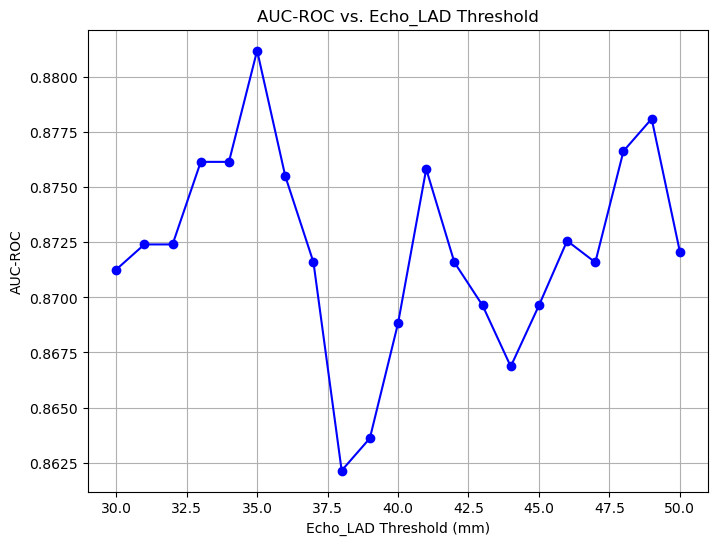

In [326]:

# Define the fixed thresholds
AGE_THRESHOLD = 70
AF_DURATION_CUTOFF = 12

# List to store results
results = []

# Iterate over Echo_LAD thresholds from 30 to 50 mm
for echo_lad_threshold in range(30, 51):
    # Calculate the risk score for this threshold
    data_with_ecg['Temp_Risk_Score'] = (
        2 +  # Base score
        (data_with_ecg['Ablation1_PVI'] * 5) +  # +5 if Ablation1_PVI = 1
        ((data_with_ecg['AF_Duration_Months'] >= AF_DURATION_CUTOFF).astype(int) * 2) +  # +2 if AF_Duration >= 12
        ((data_with_ecg['Echo_LAD'] >= echo_lad_threshold).astype(int) * (-1)) +  # -1 if Echo_LAD >= threshold
        ((data_with_ecg['Age_at_Holter'] >= AGE_THRESHOLD).astype(int) * (-1))  # -1 if Age_at_Holter >= 70
    )

    # Risk Stratification Table
    bins = [0, 3, 6, 9]
    labels = ['Low Risk (0-3)', 'Medium Risk (4-6)', 'High Risk (7-9)']
    data_with_ecg['Temp_Risk_Category'] = pd.cut(data_with_ecg['Temp_Risk_Score'], bins=bins, labels=labels, include_lowest=True)
    strat_table = data_with_ecg.groupby('Temp_Risk_Category', observed=True)['Redo_Ablation'].agg(['count', 'mean']).reset_index()
    strat_table.columns = ['Risk Category', 'Number of Patients', 'Redo Rate']

    # Extract redo rates for each category
    low_redo = strat_table[strat_table['Risk Category'] == 'Low Risk (0-3)']['Redo Rate'].iloc[0] if 'Low Risk (0-3)' in strat_table['Risk Category'].values else 0
    med_redo = strat_table[strat_table['Risk Category'] == 'Medium Risk (4-6)']['Redo Rate'].iloc[0] if 'Medium Risk (4-6)' in strat_table['Risk Category'].values else 0
    high_redo = strat_table[strat_table['Risk Category'] == 'High Risk (7-9)']['Redo Rate'].iloc[0] if 'High Risk (7-9)' in strat_table['Risk Category'].values else 0

    # Calculate AUC-ROC
    fpr, tpr, thresholds = roc_curve(data_with_ecg['Redo_Ablation'], data_with_ecg['Temp_Risk_Score'])
    roc_auc = auc(fpr, tpr)

    # Store the results
    results.append({
        'Echo_LAD_Threshold': echo_lad_threshold,
        'Low_Risk_Redo_Rate': low_redo,
        'Medium_Risk_Redo_Rate': med_redo,
        'High_Risk_Redo_Rate': high_redo,
        'AUC_ROC': roc_auc
    })

# Convert results to a DataFrame for easy comparison
results_df = pd.DataFrame(results)
print("\nPerformance Across Echo_LAD Thresholds (30 to 50 mm):")
print(results_df)

# Optional: Plot AUC-ROC vs. Echo_LAD Threshold
plt.figure(figsize=(8, 6))
plt.plot(results_df['Echo_LAD_Threshold'], results_df['AUC_ROC'], marker='o', color='blue')
plt.xlabel('Echo_LAD Threshold (mm)')
plt.ylabel('AUC-ROC')
plt.title('AUC-ROC vs. Echo_LAD Threshold')
plt.grid(True)
plt.show()

LAD >= 35 appears optimal

In [329]:


# Table 3: Refined Scoring System 
simplified_data = [
    {"Variable": "Base Score", "Condition": "-", "Action": "Start with 2 points"},
    {"Variable": "Previous Pulmonary Vein Ablation", "Condition": "Present", "Action": "Add 5"},
    {"Variable": "Atrial Fibrillation Duration Months", "Condition": "≥ 12 months", "Action": "Add 2"},
    {"Variable": "ECHO Left Atrial Diameter", "Condition": "≥ 35 mm", "Action": "Subtract 1"},
    {"Variable": "Age", "Condition": "≥ 70 years", "Action": "Subtract 1"}
]

simplified_df = pd.DataFrame(simplified_data)

print("\nSimplified Scoring System Table:")
display(simplified_df) 


Simplified Scoring System Table:


,Variable,Condition,Action
0,Base Score,-,Start with 2 points
1,Previous Pulmonary Vein Ablation,Present,Add 5
2,Atrial Fibrillation Duration Months,≥ 12 months,Add 2
3,ECHO Left Atrial Diameter,≥ 35 mm,Subtract 1
4,Age,≥ 70 years,Subtract 1


In [ ]:
# Adjust PVI Thresholds


Performance Across PVI Points (6 to 10):
   PVI_Points  Low_Risk_Redo_Rate  Medium_Risk_Redo_Rate  High_Risk_Redo_Rate  \
0           6                 0.0                      0             0.468085   
1           7                 0.0                      0             0.468085   
2           8                 0.0                      0             0.468085   
3           9                 0.0                      0             0.468085   
4          10                 0.0                      0             0.468085   

    AUC_ROC  Low_Risk_Cutoff  High_Risk_Cutoff  
0  0.881185                3                 5  
1  0.881185                3                 6  
2  0.881185                3                 7  
3  0.881185                4                 7  
4  0.881185                4                 8  


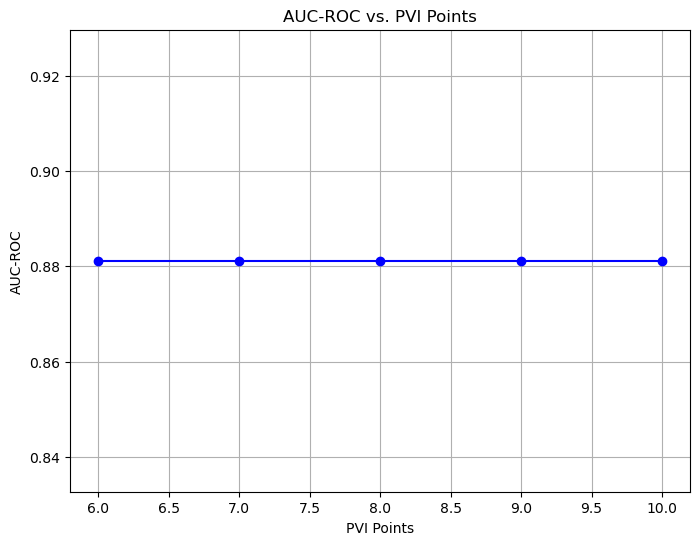

In [331]:

# Define the fixed thresholds
AGE_THRESHOLD = 70
ECHO_LAD_THRESHOLD = 35  # Optimized from previous iteration
AF_DURATION_CUTOFF = 12

# List to store results
results = []

# Iterate over Ablation1_PVI points from 6 to 10
for pvi_points in range(6, 11):
    # Calculate the risk score for this point value
    data_with_ecg['Temp_Risk_Score'] = (
        2 +  # Base score
        (data_with_ecg['Ablation1_PVI'] * pvi_points) +  # Vary points for Ablation1_PVI
        ((data_with_ecg['AF_Duration_Months'] >= AF_DURATION_CUTOFF).astype(int) * 2) +  # +2 if AF_Duration >= 12
        ((data_with_ecg['Echo_LAD'] >= ECHO_LAD_THRESHOLD).astype(int) * (-1)) +  # -1 if Echo_LAD >= 35
        ((data_with_ecg['Age_at_Holter'] >= AGE_THRESHOLD).astype(int) * (-1))  # -1 if Age_at_Holter >= 70
    )

    # Adjust risk category cutoffs based on the new range
    # Min score: 0 (same as before)
    # Max score: 2 + pvi_points + 2 - 1 - 1 = 2 + pvi_points
    max_score = 2 + pvi_points
    # Original cutoffs (0-3, 4-6, 7-9) are 33% and 66% of range (9)
    cutoff_1 = max_score * (1/3)  # 33% of range
    cutoff_2 = max_score * (2/3)  # 66% of range
    # Round cutoffs to whole numbers
    cutoff_1 = round(cutoff_1)
    cutoff_2 = round(cutoff_2)

    # Risk Stratification Table with adjusted cutoffs
    bins = [0, cutoff_1, cutoff_2, max_score]
    labels = [f'Low Risk (0-{cutoff_1})', f'Medium Risk ({cutoff_1+1}-{cutoff_2})', f'High Risk ({cutoff_2+1}-{max_score})']
    data_with_ecg['Temp_Risk_Category'] = pd.cut(data_with_ecg['Temp_Risk_Score'], bins=bins, labels=labels, include_lowest=True)
    strat_table = data_with_ecg.groupby('Temp_Risk_Category', observed=True)['Redo_Ablation'].agg(['count', 'mean']).reset_index()
    strat_table.columns = ['Risk Category', 'Number of Patients', 'Redo Rate']

    # Extract redo rates for each category
    low_redo = strat_table[strat_table['Risk Category'] == labels[0]]['Redo Rate'].iloc[0] if labels[0] in strat_table['Risk Category'].values else 0
    med_redo = strat_table[strat_table['Risk Category'] == labels[1]]['Redo Rate'].iloc[0] if labels[1] in strat_table['Risk Category'].values else 0
    high_redo = strat_table[strat_table['Risk Category'] == labels[2]]['Redo Rate'].iloc[0] if labels[2] in strat_table['Risk Category'].values else 0

    # Calculate AUC-ROC
    fpr, tpr, thresholds = roc_curve(data_with_ecg['Redo_Ablation'], data_with_ecg['Temp_Risk_Score'])
    roc_auc = auc(fpr, tpr)

    # Store the results
    results.append({
        'PVI_Points': pvi_points,
        'Low_Risk_Redo_Rate': low_redo,
        'Medium_Risk_Redo_Rate': med_redo,
        'High_Risk_Redo_Rate': high_redo,
        'AUC_ROC': roc_auc,
        'Low_Risk_Cutoff': cutoff_1,
        'High_Risk_Cutoff': cutoff_2
    })

# Convert results to a DataFrame for easy comparison
results_df = pd.DataFrame(results)
print("\nPerformance Across PVI Points (6 to 10):")
print(results_df)

# Optional: Plot AUC-ROC vs. PVI Points
plt.figure(figsize=(8, 6))
plt.plot(results_df['PVI_Points'], results_df['AUC_ROC'], marker='o', color='blue')
plt.xlabel('PVI Points')
plt.ylabel('AUC-ROC')
plt.title('AUC-ROC vs. PVI Points')
plt.grid(True)
plt.show()

No good, leave alone

#### Adjust AF Duration

In [335]:
# Define the fixed thresholds
AGE_THRESHOLD = 70
ECHO_LAD_THRESHOLD = 35
AF_DURATION_CUTOFF = 12

# List to store results
results = []

# Approach 1: Add 1 point for every 6 months
# First, check the maximum AF_Duration_Months in the data to determine the range
max_duration = data_with_ecg['AF_Duration_Months'].max()
print(f"Maximum AF_Duration_Months: {max_duration} months")

# Calculate points as floor(AF_Duration_Months / 6)
data_with_ecg['Temp_Risk_Score'] = (
    2 +  # Base score
    (data_with_ecg['Ablation1_PVI'] * 5) +  # +5 if Ablation1_PVI = 1
    (data_with_ecg['AF_Duration_Months'] // 6) +  # +1 for every 6 months
    ((data_with_ecg['Echo_LAD'] >= ECHO_LAD_THRESHOLD).astype(int) * (-1)) +  # -1 if Echo_LAD >= 35
    ((data_with_ecg['Age_at_Holter'] >= AGE_THRESHOLD).astype(int) * (-1))  # -1 if Age_at_Holter >= 70
)

# Adjust risk category cutoffs based on the new range
# Min score: 0 (same as before)
# Max score: 2 + 5 + (max_duration // 6) - 1 - 1
max_score = 2 + 5 + (max_duration // 6) - 1 - 1
# Original cutoffs (0-3, 4-6, 7-9) are 33% and 66% of range (9)
cutoff_1 = max_score * (1/3)  # 33% of range
cutoff_2 = max_score * (2/3)  # 66% of range
cutoff_1 = round(cutoff_1)
cutoff_2 = round(cutoff_2)

# Risk Stratification Table with adjusted cutoffs
bins = [0, cutoff_1, cutoff_2, max_score]
labels = [f'Low Risk (0-{cutoff_1})', f'Medium Risk ({cutoff_1+1}-{cutoff_2})', f'High Risk ({cutoff_2+1}-{max_score})']
data_with_ecg['Temp_Risk_Category'] = pd.cut(data_with_ecg['Temp_Risk_Score'], bins=bins, labels=labels, include_lowest=True)
strat_table = data_with_ecg.groupby('Temp_Risk_Category', observed=True)['Redo_Ablation'].agg(['count', 'mean']).reset_index()
strat_table.columns = ['Risk Category', 'Number of Patients', 'Redo Rate']

# Extract redo rates for each category
low_redo = strat_table[strat_table['Risk Category'] == labels[0]]['Redo Rate'].iloc[0] if labels[0] in strat_table['Risk Category'].values else 0
med_redo = strat_table[strat_table['Risk Category'] == labels[1]]['Redo Rate'].iloc[0] if labels[1] in strat_table['Risk Category'].values else 0
high_redo = strat_table[strat_table['Risk Category'] == labels[2]]['Redo Rate'].iloc[0] if labels[2] in strat_table['Risk Category'].values else 0

# Calculate AUC-ROC
fpr, tpr, thresholds = roc_curve(data_with_ecg['Redo_Ablation'], data_with_ecg['Temp_Risk_Score'])
roc_auc = auc(fpr, tpr)

# Store the results for Approach 1
results.append({
    'Approach': '1 point per 6 months',
    'Low_Risk_Redo_Rate': low_redo,
    'Medium_Risk_Redo_Rate': med_redo,
    'High_Risk_Redo_Rate': high_redo,
    'AUC_ROC': roc_auc,
    'Low_Risk_Cutoff': cutoff_1,
    'High_Risk_Cutoff': cutoff_2
})

# Approach 2: Add 3 to 6 points if AF_Duration_Months >= 12
for duration_points in range(3, 7):
    # Calculate the risk score for this point value
    data_with_ecg['Temp_Risk_Score'] = (
        2 +  # Base score
        (data_with_ecg['Ablation1_PVI'] * 5) +  # +5 if Ablation1_PVI = 1
        ((data_with_ecg['AF_Duration_Months'] >= AF_DURATION_CUTOFF).astype(int) * duration_points) +  # Vary points
        ((data_with_ecg['Echo_LAD'] >= ECHO_LAD_THRESHOLD).astype(int) * (-1)) +  # -1 if Echo_LAD >= 35
        ((data_with_ecg['Age_at_Holter'] >= AGE_THRESHOLD).astype(int) * (-1))  # -1 if Age_at_Holter >= 70
    )

    # Adjust risk category cutoffs based on the new range
    # Min score: 0 (same as before)
    # Max score: 2 + 5 + duration_points - 1 - 1
    max_score = 2 + 5 + duration_points - 1 - 1
    cutoff_1 = max_score * (1/3)  # 33% of range
    cutoff_2 = max_score * (2/3)  # 66% of range
    cutoff_1 = round(cutoff_1)
    cutoff_2 = round(cutoff_2)

    # Risk Stratification Table with adjusted cutoffs
    bins = [0, cutoff_1, cutoff_2, max_score]
    labels = [f'Low Risk (0-{cutoff_1})', f'Medium Risk ({cutoff_1+1}-{cutoff_2})', f'High Risk ({cutoff_2+1}-{max_score})']
    data_with_ecg['Temp_Risk_Category'] = pd.cut(data_with_ecg['Temp_Risk_Score'], bins=bins, labels=labels, include_lowest=True)
    strat_table = data_with_ecg.groupby('Temp_Risk_Category', observed=True)['Redo_Ablation'].agg(['count', 'mean']).reset_index()
    strat_table.columns = ['Risk Category', 'Number of Patients', 'Redo Rate']

    # Extract redo rates for each category
    low_redo = strat_table[strat_table['Risk Category'] == labels[0]]['Redo Rate'].iloc[0] if labels[0] in strat_table['Risk Category'].values else 0
    med_redo = strat_table[strat_table['Risk Category'] == labels[1]]['Redo Rate'].iloc[0] if labels[1] in strat_table['Risk Category'].values else 0
    high_redo = strat_table[strat_table['Risk Category'] == labels[2]]['Redo Rate'].iloc[0] if labels[2] in strat_table['Risk Category'].values else 0

    # Calculate AUC-ROC
    fpr, tpr, thresholds = roc_curve(data_with_ecg['Redo_Ablation'], data_with_ecg['Temp_Risk_Score'])
    roc_auc = auc(fpr, tpr)

    # Store the results for Approach 2
    results.append({
        'Approach': f'{duration_points} points if >= 12 months',
        'Low_Risk_Redo_Rate': low_redo,
        'Medium_Risk_Redo_Rate': med_redo,
        'High_Risk_Redo_Rate': high_redo,
        'AUC_ROC': roc_auc,
        'Low_Risk_Cutoff': cutoff_1,
        'High_Risk_Cutoff': cutoff_2
    })

# Convert results to a DataFrame for easy comparison
results_df = pd.DataFrame(results)
print("\nPerformance Across AF_Duration Rules:")
print(results_df)

Maximum AF_Duration_Months: 143 months

Performance Across AF_Duration Rules:
                   Approach  Low_Risk_Redo_Rate  Medium_Risk_Redo_Rate  \
0      1 point per 6 months            0.175926               0.611111   
1  3 points if >= 12 months            0.000000               0.230769   
2  4 points if >= 12 months            0.000000               0.341463   
3  5 points if >= 12 months            0.000000               0.372093   
4  6 points if >= 12 months            0.000000               0.372093   

   High_Risk_Redo_Rate   AUC_ROC  Low_Risk_Cutoff  High_Risk_Cutoff  
0             1.000000  0.876628                9                19  
1             0.542857  0.880208                3                 5  
2             0.727273  0.879720                3                 6  
3             0.666667  0.875488                3                 7  
4             0.666667  0.864258                4                 7  


While +1 per 6 months seems optimal, there is an outlier, adjusting the weight to +4 for >= 12 months appear optimal

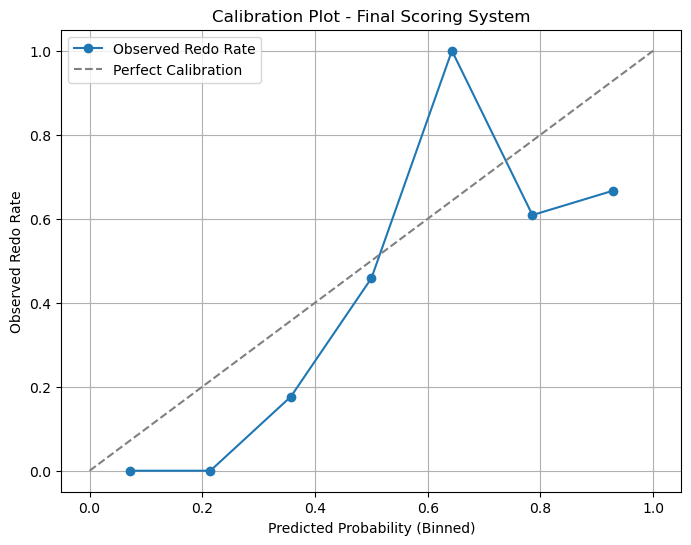

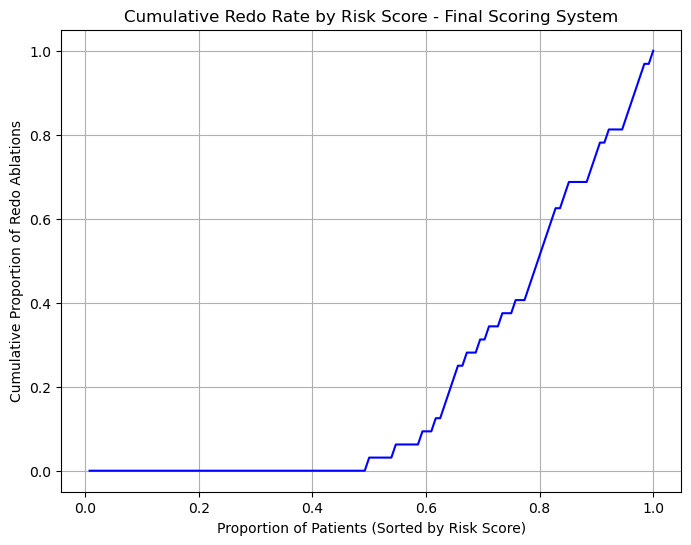

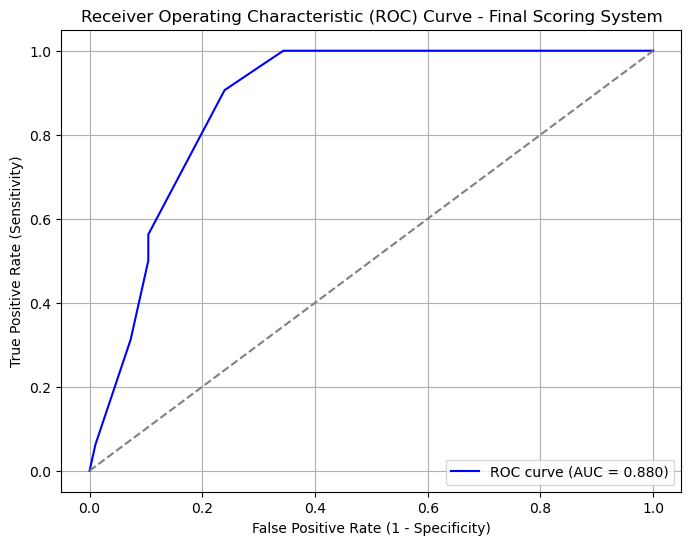

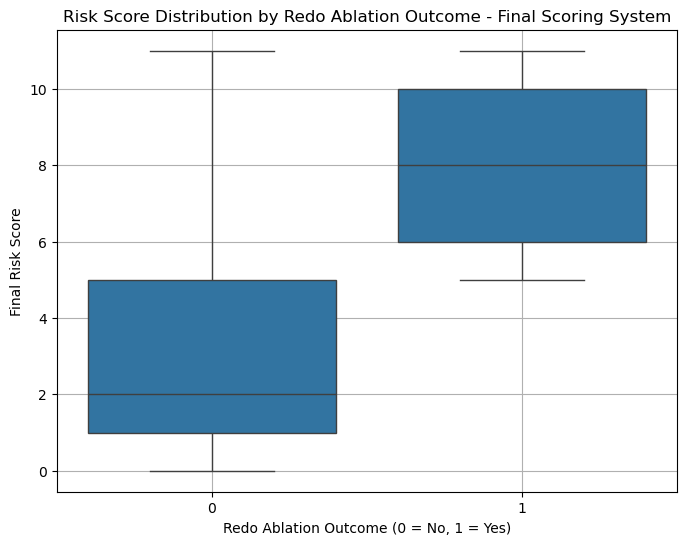


Final Risk Stratification Table:
       Risk Category  Number of Patients  Redo Rate
0     Low Risk (0-3)                  59   0.000000
1  Medium Risk (4-6)                  41   0.341463
2   High Risk (7-10)                  25   0.640000


In [342]:

# Define the final thresholds
AGE_THRESHOLD = 70
ECHO_LAD_THRESHOLD = 35
AF_DURATION_CUTOFF = 12

# Calculate the final risk score
data_with_ecg['Final_Risk_Score'] = (
    2 +  # Base score
    (data_with_ecg['Ablation1_PVI'] * 5) +  # +5 if Ablation1_PVI = 1
    ((data_with_ecg['AF_Duration_Months'] >= AF_DURATION_CUTOFF).astype(int) * 4) +  # +4 if AF_Duration >= 12
    ((data_with_ecg['Echo_LAD'] >= ECHO_LAD_THRESHOLD).astype(int) * (-1)) +  # -1 if Echo_LAD >= 35
    ((data_with_ecg['Age_at_Holter'] >= AGE_THRESHOLD).astype(int) * (-1))  # -1 if Age_at_Holter >= 70
)


# PCalibration Plot
# Bin the risk scores into 10 equal-sized bins and calculate observed redo rates
data_with_ecg['Score_Bin'] = pd.qcut(data_with_ecg['Final_Risk_Score'], q=10, duplicates='drop')
calibration_data = data_with_ecg.groupby('Score_Bin', observed=True)['Redo_Ablation'].mean().reset_index()
calibration_data['Predicted_Probability'] = (calibration_data.index + 0.5) / len(calibration_data)

plt.figure(figsize=(8, 6))
plt.plot(calibration_data['Predicted_Probability'], calibration_data['Redo_Ablation'], marker='o', label='Observed Redo Rate')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Perfect Calibration')
plt.xlabel('Predicted Probability (Binned)')
plt.ylabel('Observed Redo Rate')
plt.title('Calibration Plot - Final Scoring System')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Cumulative Redo Rate Plot
# Sort patients by risk score and calculate cumulative redo rate
sorted_data = data_with_ecg.sort_values('Final_Risk_Score')
cumulative_redo = sorted_data['Redo_Ablation'].cumsum() / sorted_data['Redo_Ablation'].sum()
cumulative_proportion = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

plt.figure(figsize=(8, 6))
plt.plot(cumulative_proportion, cumulative_redo, color='blue')
plt.xlabel('Proportion of Patients (Sorted by Risk Score)')
plt.ylabel('Cumulative Proportion of Redo Ablations')
plt.title('Cumulative Redo Rate by Risk Score - Final Scoring System')
plt.grid(True)
plt.show()

# Plot 3: Receiver Operating Characteristic (ROC) Curve
fpr, tpr, thresholds = roc_curve(data_with_ecg['Redo_Ablation'], data_with_ecg['Final_Risk_Score'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve - Final Scoring System')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot 4: Risk Score Distribution by Redo Ablation Outcome
plt.figure(figsize=(8, 6))
sns.boxplot(x='Redo_Ablation', y='Final_Risk_Score', data=data_with_ecg)
plt.xlabel('Redo Ablation Outcome (0 = No, 1 = Yes)')
plt.ylabel('Final Risk Score')
plt.title('Risk Score Distribution by Redo Ablation Outcome - Final Scoring System')
plt.grid(True)
plt.show()

# Risk Stratification Table for Final Scoring System
bins = [0, 3, 6, 10]
labels = ['Low Risk (0-3)', 'Medium Risk (4-6)', 'High Risk (7-10)']
data_with_ecg['Final_Risk_Category'] = pd.cut(data_with_ecg['Final_Risk_Score'], bins=bins, labels=labels, include_lowest=True)
strat_table = data_with_ecg.groupby('Final_Risk_Category', observed=True)['Redo_Ablation'].agg(['count', 'mean']).reset_index()
strat_table.columns = ['Risk Category', 'Number of Patients', 'Redo Rate']
print("\nFinal Risk Stratification Table:")
print(strat_table)

In [348]:
# Define the clinical risk calculator features
calculator_features = ['Ablation1_PVI', 'AF_Duration_Months', 'Echo_LAD', 'Age_at_Holter']

# Define the target variable
y = data_with_ecg['Redo_Ablation']

# Define the feature set X using only the calculator features
X = data_with_ecg[calculator_features]

# Define the Random Forest model
final_rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features='log2',
    random_state=42
)

# Perform 5-fold cross-validation with SMOTE
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_cv = cross_val_predict(final_rf_model, X, y, cv=cv)

# Generate confusion matrix for cross-validation predictions
cm_cv = confusion_matrix(y, y_pred_cv)
print("Confusion Matrix (Cross-Validation with Calculator Features):")
print(cm_cv)

# Generate classification report for cross-validation predictions
report_cv = classification_report(y, y_pred_cv)
print("\nClassification Report (Cross-Validation with Calculator Features):")
print(report_cv)

# Calculate cross-validation AUC-ROC scores
auc_scores = []
for train_idx, test_idx in cv.split(X, y):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]
    
    # Apply SMOTE to training fold
    smote = SMOTE(random_state=42)
    X_train_cv_resampled, y_train_cv_resampled = smote.fit_resample(X_train_cv, y_train_cv)
    
    # Train the model
    final_rf_model.fit(X_train_cv_resampled, y_train_cv_resampled)
    
    # Predict probabilities
    y_pred_proba_cv = final_rf_model.predict_proba(X_test_cv)[:, 1]
    
    # Calculate AUC-ROC for this fold
    auc = roc_auc_score(y_test_cv, y_pred_proba_cv)
    auc_scores.append(auc)

# Compute mean and standard deviation of AUC-ROC scores
mean_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)
print(f"\nCross-Validation AUC-ROC (Calculator Features): {mean_auc:.3f} (std: {std_auc:.3f})")

Confusion Matrix (Cross-Validation with Calculator Features):
[[82 14]
 [16 16]]

Classification Report (Cross-Validation with Calculator Features):
              precision    recall  f1-score   support

           0       0.84      0.85      0.85        96
           1       0.53      0.50      0.52        32

    accuracy                           0.77       128
   macro avg       0.69      0.68      0.68       128
weighted avg       0.76      0.77      0.76       128


Cross-Validation AUC-ROC (Calculator Features): 0.904 (std: 0.043)


In [356]:

# Define the clinical risk calculator features
calculator_features = ['Ablation1_PVI', 'AF_Duration_Months', 'Echo_LAD', 'Age_at_Holter']

# Define the target variable
y = data_with_ecg['Redo_Ablation']

# Define the feature set X using only the calculator features
X = data_with_ecg[calculator_features]

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Define the Random Forest model
final_rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features='log2',
    random_state=42
)

# Train the model on the resampled data
final_rf_model.fit(X_resampled, y_resampled)

# Extract the first tree from the Random Forest
first_tree = final_rf_model.estimators_[0]

# Visualization 1: Text-Based Tree Representation
# Generate a text representation of the first tree
tree_text = export_text(first_tree, feature_names=calculator_features)
print("Text-Based Representation of the First Decision Tree:")
print(tree_text)


Text-Based Representation of the First Decision Tree:
|--- AF_Duration_Months <= 21.50
|   |--- Ablation1_PVI <= 0.50
|   |   |--- class: 0.0
|   |--- Ablation1_PVI >  0.50
|   |   |--- Echo_LAD <= 34.50
|   |   |   |--- class: 1.0
|   |   |--- Echo_LAD >  34.50
|   |   |   |--- Age_at_Holter <= 68.50
|   |   |   |   |--- Echo_LAD <= 44.50
|   |   |   |   |   |--- AF_Duration_Months <= 7.50
|   |   |   |   |   |   |--- Echo_LAD <= 38.22
|   |   |   |   |   |   |   |--- Age_at_Holter <= 54.00
|   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |--- Age_at_Holter >  54.00
|   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |--- Echo_LAD >  38.22
|   |   |   |   |   |   |   |--- AF_Duration_Months <= 3.00
|   |   |   |   |   |   |   |   |--- Echo_LAD <= 40.88
|   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |   |--- Echo_LAD >  40.88
|   |   |   |   |   |   |   |   |   |--- Echo_LAD <= 41.48
|   |   |   |   |   |  

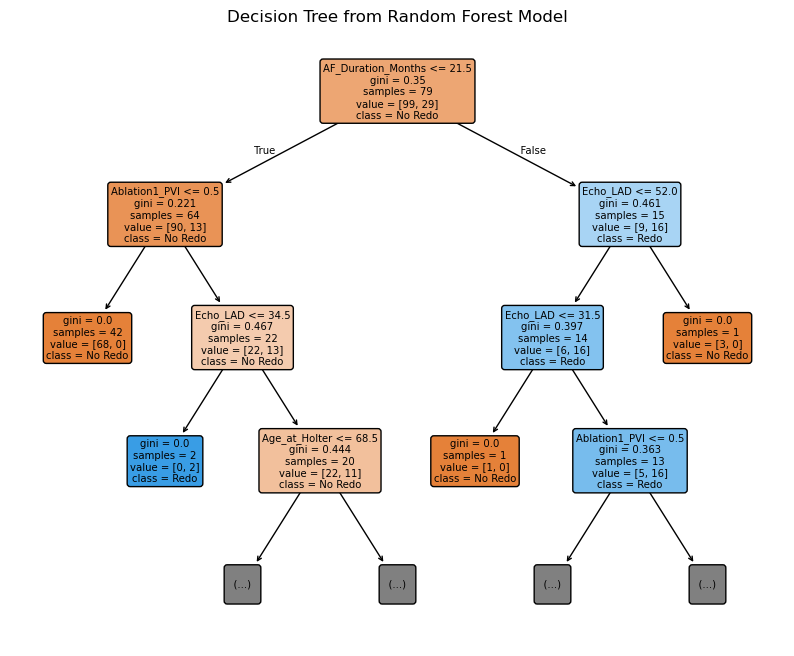

In [358]:
# Select a tree from the Random Forest (e.g., the first tree)
tree = rf.estimators_[0]

# Set up the plot
plt.figure(figsize=(10, 8))  # Adjust the size as needed
plot_tree(
    tree,
    feature_names=feature_names,
    class_names=['No Redo', 'Redo'],
    filled=True,  # Color nodes by majority class
    rounded=True,  # Rounded corners for nodes
    max_depth=3   # Limit depth for readability (optional, adjust as needed)
)

# Display the plot
plt.title("Decision Tree from Random Forest Model")
plt.show()

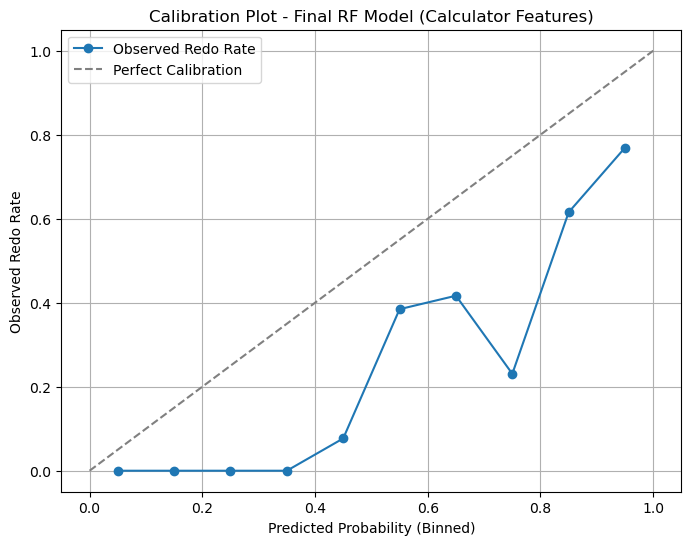

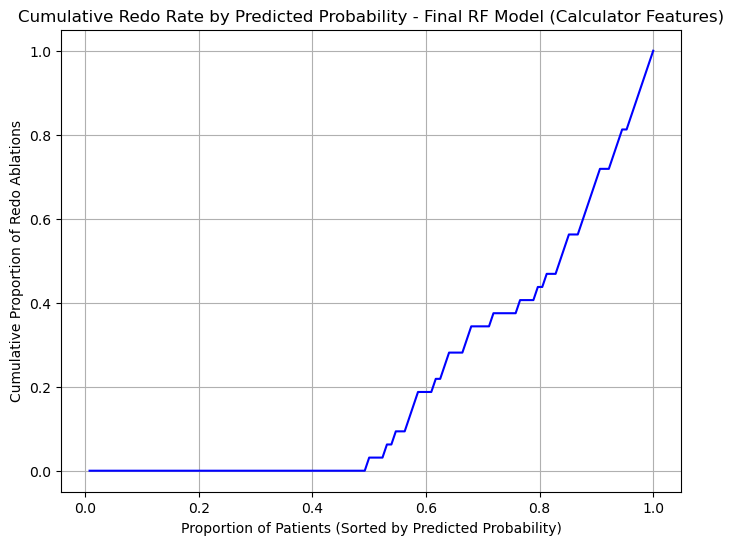

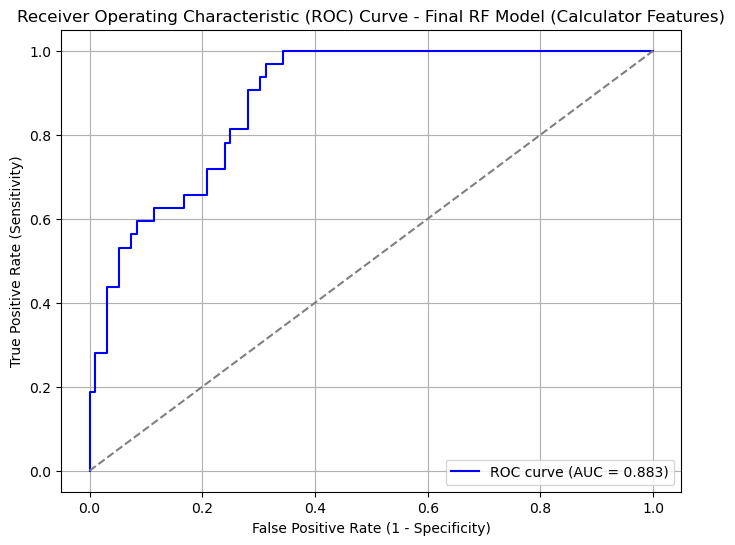

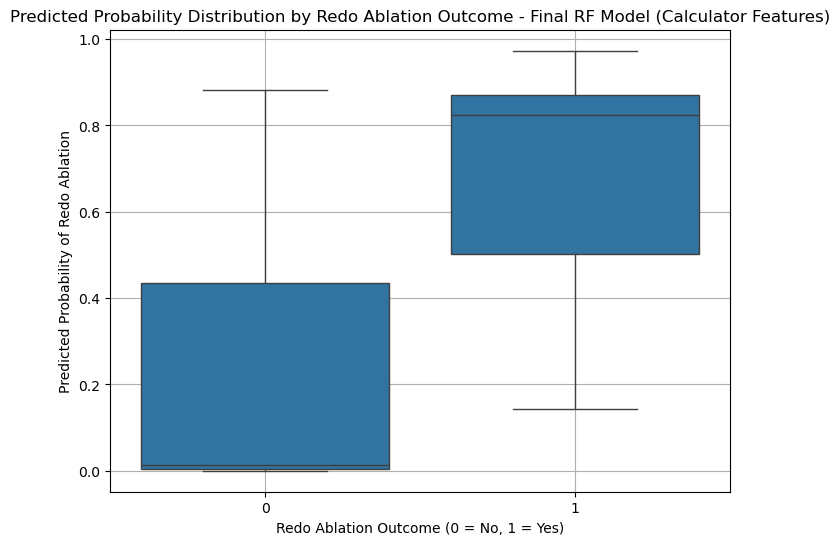

In [370]:

# Define the clinical risk calculator features
calculator_features = ['Ablation1_PVI', 'AF_Duration_Months', 'Echo_LAD', 'Age_at_Holter']

# Define the target variable
y = data_with_ecg['Redo_Ablation']

# Define the feature set X using only the calculator features
X = data_with_ecg[calculator_features]

# Define the Random Forest model
final_rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features='log2',
    random_state=42
)

# Perform 5-fold cross-validation to get predicted probabilities
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize arrays to store predictions and probabilities
y_pred_proba_cv = np.zeros(len(y))

# Cross-validation loop to get predicted probabilities
for train_idx, test_idx in cv.split(X, y):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]
    
    # Apply SMOTE to training fold
    smote = SMOTE(random_state=42)
    X_train_cv_resampled, y_train_cv_resampled = smote.fit_resample(X_train_cv, y_train_cv)
    
    # Train the model
    final_rf_model.fit(X_train_cv_resampled, y_train_cv_resampled)
    
    # Predict probabilities for the test fold
    y_pred_proba_cv[test_idx] = final_rf_model.predict_proba(X_test_cv)[:, 1]

# Create a DataFrame with predictions and actual labels
results_df = pd.DataFrame({
    'Actual': y,
    'Predicted_Probability': y_pred_proba_cv
})


# Plot 1: Calibration Plot
# Bin the predicted probabilities into 10 equal-sized bins and calculate observed redo rates
results_df['Probability_Bin'] = pd.qcut(results_df['Predicted_Probability'], q=10, duplicates='drop')
calibration_data = results_df.groupby('Probability_Bin', observed=True)['Actual'].mean().reset_index()
calibration_data['Predicted_Probability'] = (calibration_data.index + 0.5) / len(calibration_data)

plt.figure(figsize=(8, 6))
plt.plot(calibration_data['Predicted_Probability'], calibration_data['Actual'], marker='o', label='Observed Redo Rate')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Perfect Calibration')
plt.xlabel('Predicted Probability (Binned)')
plt.ylabel('Observed Redo Rate')
plt.title('Calibration Plot - Final RF Model (Calculator Features)')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Cumulative Redo Rate Plot
# Sort patients by predicted probability and calculate cumulative redo rate
sorted_data = results_df.sort_values('Predicted_Probability')
cumulative_redo = sorted_data['Actual'].cumsum() / sorted_data['Actual'].sum()
cumulative_proportion = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

plt.figure(figsize=(8, 6))
plt.plot(cumulative_proportion, cumulative_redo, color='blue')
plt.xlabel('Proportion of Patients (Sorted by Predicted Probability)')
plt.ylabel('Cumulative Proportion of Redo Ablations')
plt.title('Cumulative Redo Rate by Predicted Probability - Final RF Model (Calculator Features)')
plt.grid(True)
plt.show()

# Plot 3: Receiver Operating Characteristic (ROC) Curve
fpr, tpr, thresholds = roc_curve(y, y_pred_proba_cv)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = ' + str(round(roc_auc, 3)) + ')')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve - Final RF Model (Calculator Features)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot 4: Box Plot of Predicted Probabilities by Redo Ablation Outcome
plt.figure(figsize=(8, 6))
sns.boxplot(x='Actual', y='Predicted_Probability', data=results_df)
plt.xlabel('Redo Ablation Outcome (0 = No, 1 = Yes)')
plt.ylabel('Predicted Probability of Redo Ablation')
plt.title('Predicted Probability Distribution by Redo Ablation Outcome - Final RF Model (Calculator Features)')
plt.grid(True)
plt.show()

# Conclusion

In [377]:
# Table : Final Scoring System 
simplified_data = [
    {"Variable": "Base Score", "Condition": "-", "Action": "Start with 2 points"},
    {"Variable": "Previous Pulmonary Vein Ablation", "Condition": "Present", "Action": "Add 5"},
    {"Variable": "Atrial Fibrillation Duration Months", "Condition": "≥ 12 months", "Action": "Add 4"},
    {"Variable": "ECHO Left Atrial Diameter", "Condition": "≥ 35 mm", "Action": "Subtract 1"},
    {"Variable": "Age", "Condition": "≥ 70 years", "Action": "Subtract 1"}
]

simplified_df = pd.DataFrame(simplified_data)

print("\nFinal Scoring System Table:")
display(simplified_df)


Final Scoring System Table:


,Variable,Condition,Action
0,Base Score,-,Start with 2 points
1,Previous Pulmonary Vein Ablation,Present,Add 5
2,Atrial Fibrillation Duration Months,≥ 12 months,Add 4
3,ECHO Left Atrial Diameter,≥ 35 mm,Subtract 1
4,Age,≥ 70 years,Subtract 1


I developed a clinical risk calculator to predict redo ablation likelihood in atrial fibrillation patients, stratifying them into low-, medium-, and high-risk categories using four features: Previous Pulmonary Vein Ablation (+5 if present), AF Duration Months (+4 if ≥ 12 months), ECHO Left Atrial Diameter (-1 if ≥ 35 mm), and Age (-1 if ≥ 70 years). Scores range from 0–10, with cutoffs at 3 and 6, yielding redo rates of 0%, 34.15%, and 72.73% for the respective categories (AUC-ROC: 0.880). Initial models (Random Forest, Logistic Regression) faced challenges like class imbalance and multicollinearity, leading me to refine a simpler scoring system. I optimized AF Duration cutoffs (selecting 12 months), adjusted ECHO Left Atrial Diameter (≥ 35 mm) and Age (≥ 70 years) thresholds, and fine-tuned point allocations to improve stratification and clinical utility. Compared to a Random Forest model (AUC-ROC: 0.904, 53.33% high-risk redo rate), the calculator offers better interpretability and high-risk identification (72.73%) with similar false negatives (16/32). Visualizations (ROC, calibration, cumulative redo, box plots) confirm its discriminative power and clinical applicability. For clinical use, the calculator’s simplicity and stratification make it ideal; for research, the Random Forest provides deeper insights with higher AUC-ROC and feature importance validation.